In [2]:
%run init_notebookspace.py
from settings import *

## Table of Content
* [Introduction](#chapter0)
* [Get Italy data](#chapter1)
* [Preprocessing the data](#chapter2)
    * [Train Test Split](#section_2_1)
    * [Log-Transformation of the Data](#section_2_2)
    * [Detrend the Data](#section_2_3)
    * [Deseasonalize the Data](#section_2_4)
        * [OLS method](#subsection_1)
        * [HP filter](#subsection_2)
* [Make RBC Model](#chapter3)
    * [Model Equations](#section_3_1)
    * [Find Steady State, Solve the Model](#section_3_2)
    * [Check Blanchard Kahn Conditions](#section_3_3)
* [Maximum Likelihood Estimation](#chapter4)
    * [A Simple Model](#section_4_1)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_1)
        * [Forecasting](#subsection_4_2)
    * [A Noisy Model](#section_4_2)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_3)
        * [Forecasting](#subsection_4_4)
    * [Adding Variables](#section_4_3)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_5)
        * [Forecasting](#subsection_4_6)
    * [Final Model](#section_4_4)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_7)
        * [Forecasting](#subsection_4_8)
    * [Impulse response](#section_4_5)
        * [New Steady State](#subsection_4_9)

## Introduction <a class="anchor" id="chapter0"></a>

The aim of this paper is to fit the RBC model for Italy. 
The source of all the data is the National Institute of Statistics of Italy (ISTAT) and his database. 
The parameters use instead are taken from
1. the official site of the Bank of Italy (https://www.bancaditalia.it/compiti/ricerca-economica/modelli-macroeconomici/index.html?com.dotmarketing.htmlpage.language=1)
2.  Jerger, Jürgen; Röhe, Oke (2012) : Testing for Parameter Stability in DSGE Models. The Cases of France, Germany, Italy, and Spain, BGPE Discussion Paper, No. 118, Friedrich-Alexander-Universität Erlangen-Nürnberg, Bavarian Graduate Program in Economics (BGPE), Nürnberg 
3. Gottlieb, Onken, Valladares-Esteban (2021): On the Measurement of the Elasticity of Labour, European Economic Review, Volume 139, 103879, ISSN 0014-2921
4. Marino (2016) : The Italian productivity solwdown in a Real Business Cycle perspective, Int Rev Econ, 63, pages 171-193.


In [3]:
%matplotlib inline
import gEcon as ge
import gEcon.plotting as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az

import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df, get_seasonal_hp, arr_adf, apply_func, poly_detrend, ADF_test_summary, plot_sm_results
from src.utils import get_max_seasonal, OLS_dummie_deseasonal

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()
    pass

## Get Italy data <a class="anchor" id="chapter2"></a>

Once built a complete dataset in csv format, here we import series for consumption, investment, labor (in the form hours worked), GDP (at current prices, non deseasonalized), real interest rate , and wages (for non farm workers).

In [6]:
data = pd.read_csv(os.path.join(DATA_DIR, "all_rbc_data.csv"), infer_datetime_format="QS")
data["TIME"] = time_format(data.TIME)
data.set_index("TIME", drop=True, inplace=True)
data.sort_index(inplace=True)

# assign new column names
data.rename(columns=dict(zip(data.columns, ["Y", "I", "Z", "X", "r", "C", "w", "L"])), inplace=True)

# drop exports imports, not required
data.drop(["X", "Z"], axis=1, inplace=True)

In [7]:
glob_cols = list(data.columns)
plot_vars = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w']

## Prepocessing the Data <a class="anchor" id="chapter3"></a>

In this section more work on the data has been done; we have:
- split the data (as suggested) to have a train dataset to build the model and a test dataset to see if it works properly
- log linearized the variables
- detrend and deseasonalized the variables


In [8]:
# check for na
print(f"NaNs \n{data.isna().sum()}")

NaNs 
Y     0
I     0
r     0
C     0
w    36
L     0
dtype: int64


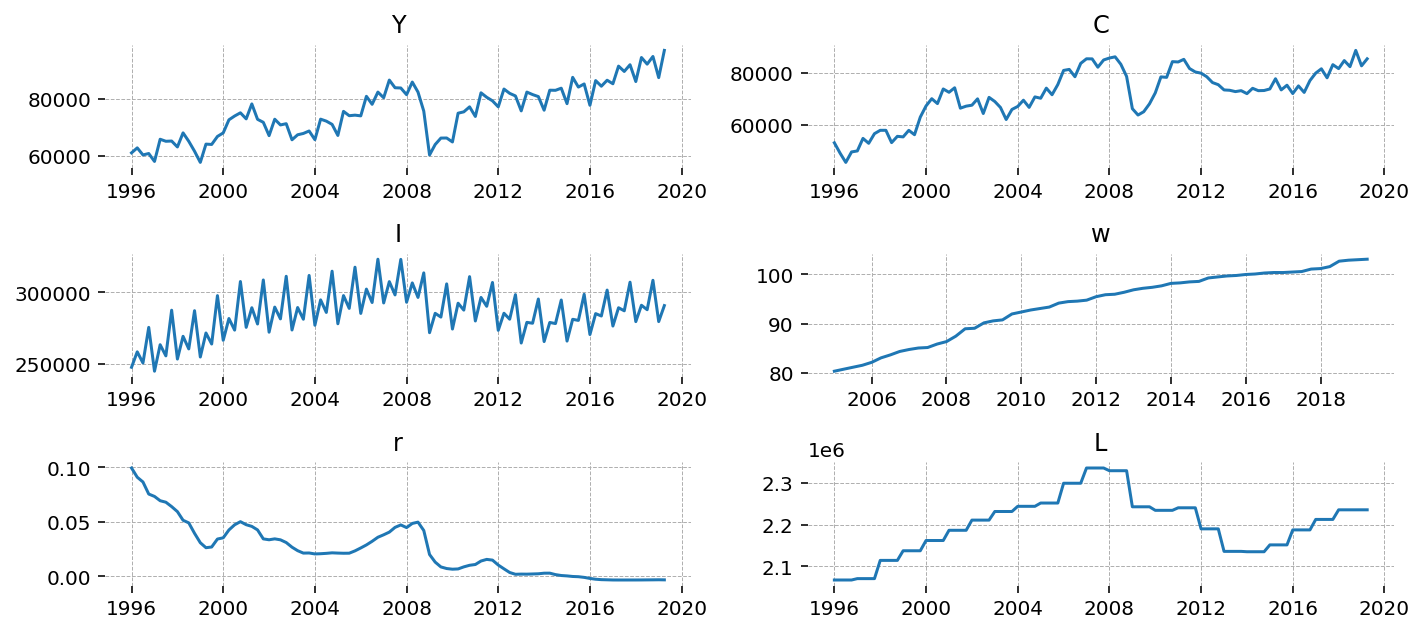

In [9]:
# raw data
plot_df(data)

The plots show the most important variable that we study in economics.
As we can see, the real GDP follows a positive trend. In 2009, the GDP decreases due to the Great Recession, then Italy recovers. Consumptions also follows a positive trend, with the same decrease in 2009. Investments are much more volatile in the movements (it is possible to see their seasonality) and the effect of economic crisis are less evident (probably because the proxy of investment is gross capital investment). Average wages constantly increase during all the period. The dynamics of the real interest rate is on the contrary: r decreases for the entire period with the expetion of 2006 and 2007, as a consequence of restrictive measure to prevent the economic crisis. In the last periods r is less than 0. Comparing r with I we can see (even if not so clear) their negative relation. In the end the labor for which we use hours per week, has peak before 2009, then decrease for 5 years before recovering.
Two important notes: the analysis is cutted before 2020, because it is very difficult to have good prediction during the pandemic and in our analysis we don't focus on the public expediture even though one of the problem of Italy is the amount of debt, better analyzed using the Government Debt over GDP which between 1996 changes from 119% to 134%.

### Train Test Split <a class="anchor" id="section_2_1"></a>

We are splitting data into a testing and training data set, which will follow the same preprossesing. It is important to note that all data specific transformations applied to 'test' are based on the training data.

In [10]:
test_size = 0.15
test_index = len(data.index) - round(len(data.index) * test_size)
test_size = len(data) - test_index
print(f"Test size: {test_size} \nTrain size: {test_index}")

Test size: 14 
Train size: 80


In [11]:
train = data.iloc[:test_index].copy()
test = data.iloc[test_index:].copy()

### Log-transformation of the Data <a class="anchor" id="section_2_2"></a>

In [12]:
# log transform
for col in [item for item in glob_cols if item != "r"]:
    train[col] = apply_func(train[col], func=np.log)
    test[col] = apply_func(test[col], func=np.log)

Raw data is log transformed, thus somehow equalised in scale

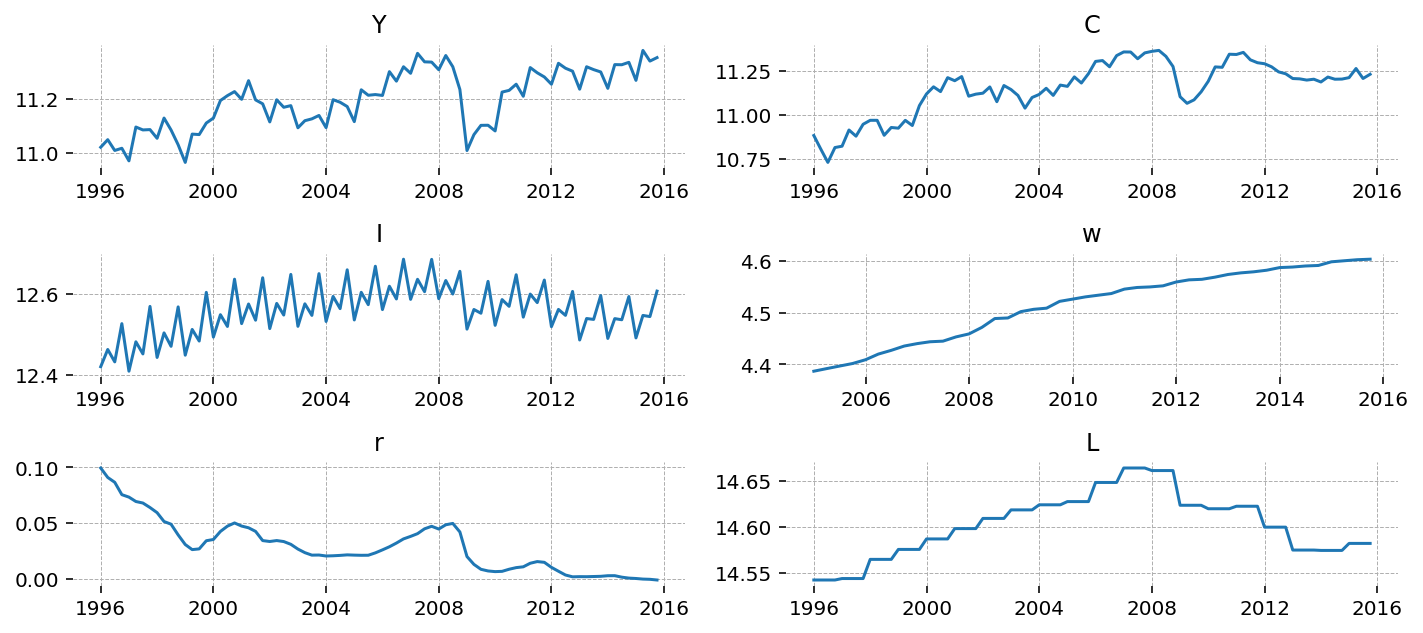

In [13]:
plot_df(train)

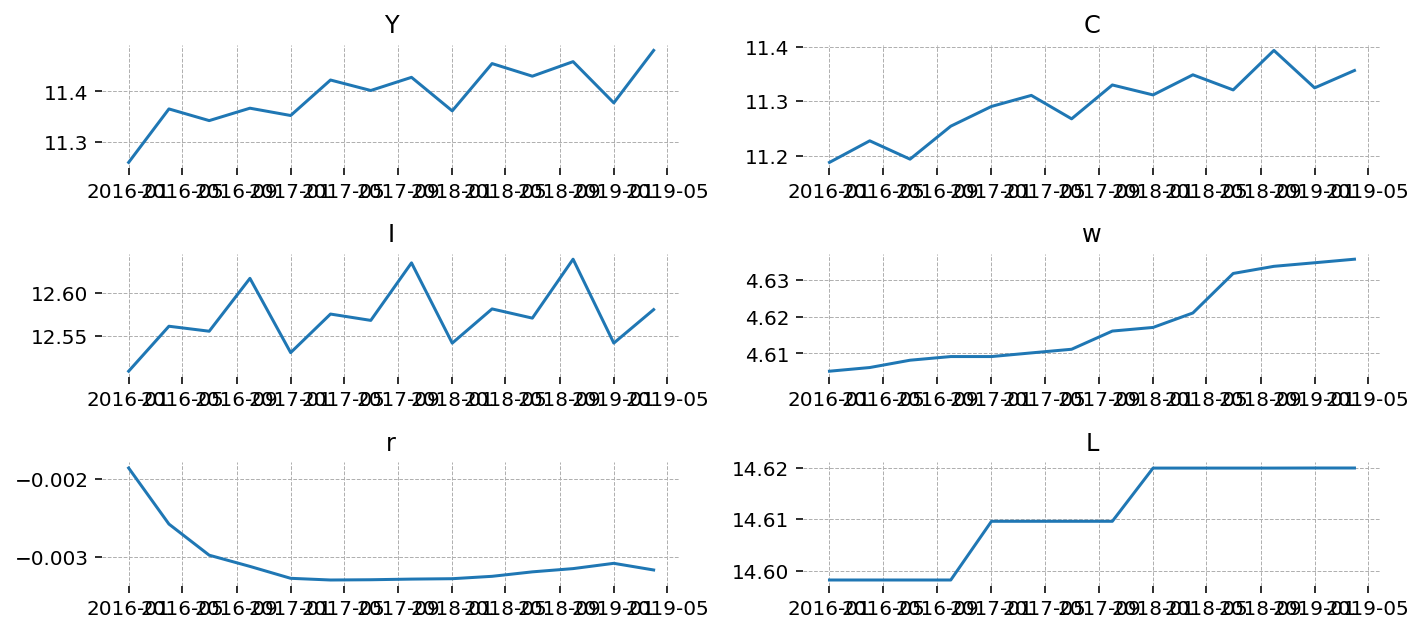

In [14]:
plot_df(test)

### Detrend the Data <a class="anchor" id="section_3_3"></a>

We apply a polynomial detrender to the data. Depending on the variables we have used polynomials of degree 1 or 2. The reason is that not every variables (look at the plots before) follow a clear linear trend. 
Interest rate is left out because it is set by CB thus no 'trend' in time series terms.

In [15]:
poly_order = {"Y": 1, 
              "C": 2, 
              "I": 2,
              "w": 1,
              "L": 2}
mask = train.copy()
for col in [item for item in glob_cols if item != 'r']:
    _ = train[col].dropna().copy()
    func_form = np.polyfit(list(range(0, len(_))), _, poly_order[col])
    
    train[col] = poly_detrend(train[col], poly_order=poly_order[col], skipna=True)   
    test[col] = poly_detrend(test[col], poly_order=poly_order[col], skipna=True)   
    mask[col] = poly_detrend(train[col], poly_order=poly_order[col], skipna=True, return_pred=True)
       
#     test[col] = np.polyval(func_form, test[col])

In [16]:
# interest rate is stationary at 10% level
ADF_test_summary(train['r'])

                                                      r                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.103         -3.340        0.060          1    -4.080      -3.468     -3.161
	Constant             0.005          2.620        0.011
	Trend               -0.000         -2.375        0.020
Constant Only               -0.043         -2.368        0.151          1    -3.517      -2.899     -2.587
	Constant             0.001          1.135        0.260
No Constant                 -0.027         -2.361        0.018          1    -2.595      -1.945     -1.614


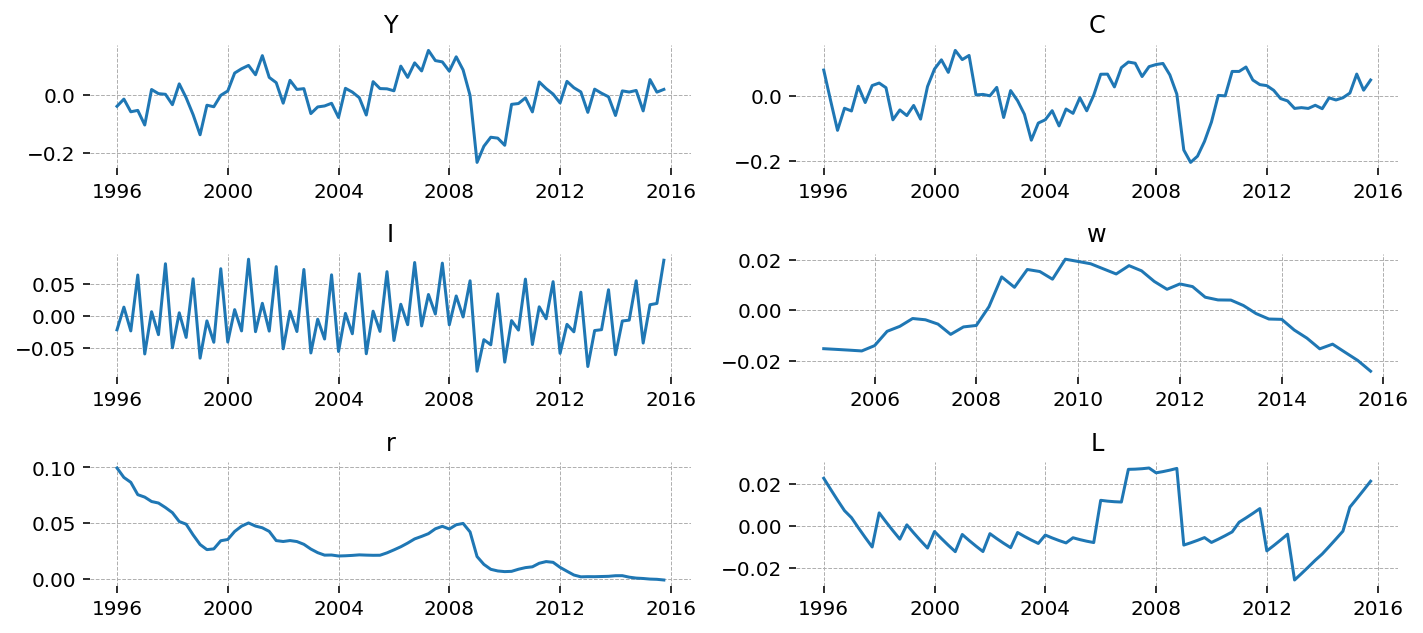

In [17]:
plot_df(train)

To comment a little about the volatility of the variables it is better to do it once we have only log-linearized and detrended and not deseasonalized. As we can note, investments are more volatile than consumptions, and the GDP tends to follow more the volatilty of consumptions because they accounts for the larger share of income.

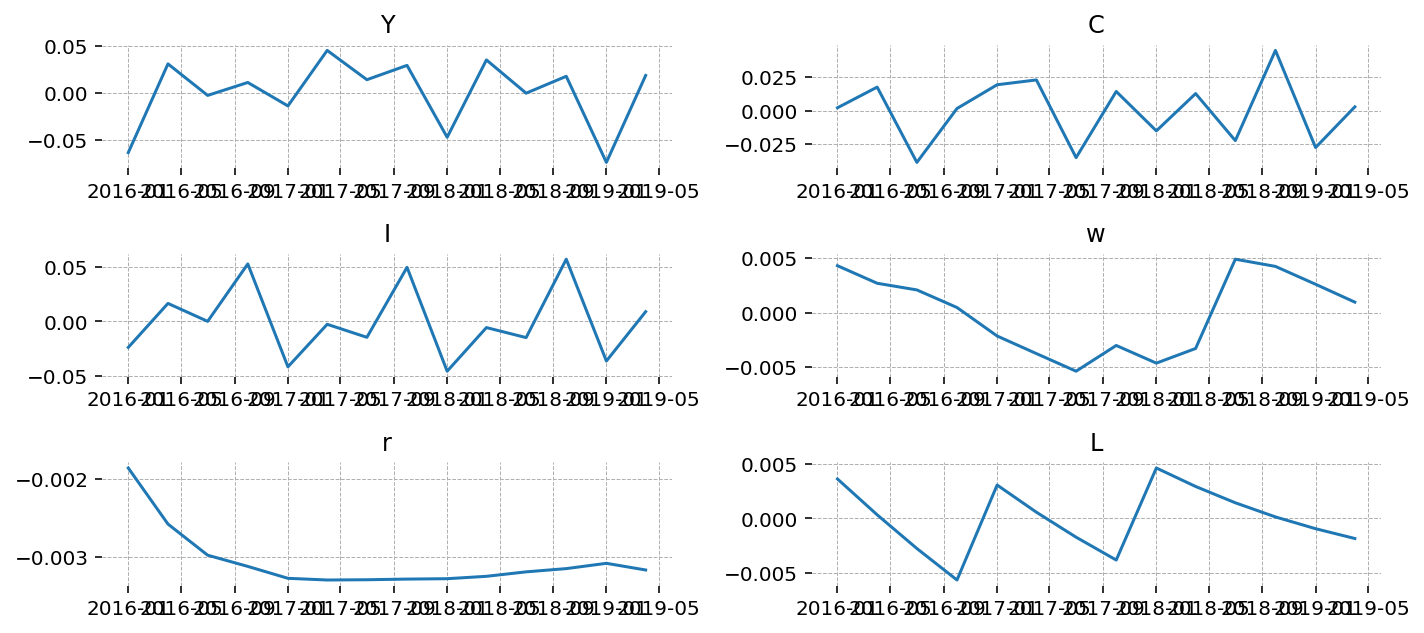

In [18]:
plot_df(test)

### Deseasonalize the Data <a class="anchor" id="section_3_2"></a>

In [19]:
_ = get_max_seasonal(train, ) #train.drop("w", axis=1))

Y: strongest effect at 2 lags
I: strongest effect at 16 lags
r: strongest effect at 2 lags
C: strongest effect at 3 lags
w: strongest effect at 2 lags
L: strongest effect at 2 lags


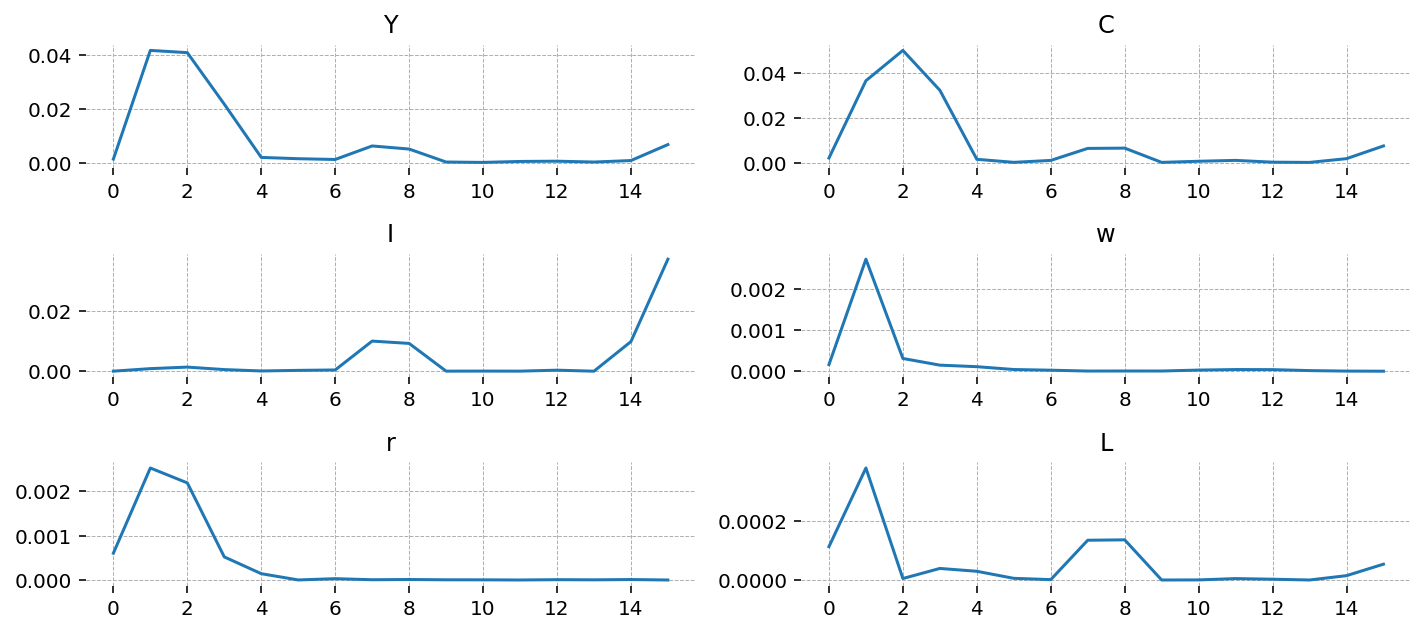

In [20]:
plot_df(_)

In [21]:
_train = train.copy()
_test = test.copy()

#### OLS method <a class="anchor" id="subsection_1"></a>

In [22]:
for col in glob_cols: # r is also seasonal as real r might fluctuate with inflation (which it self is seasonal) while CB holds i constant
    model = OLS_dummie_deseasonal()
    _train[col] = model.get_trend(train[col])
    _test[col] = model.predict(test[col])

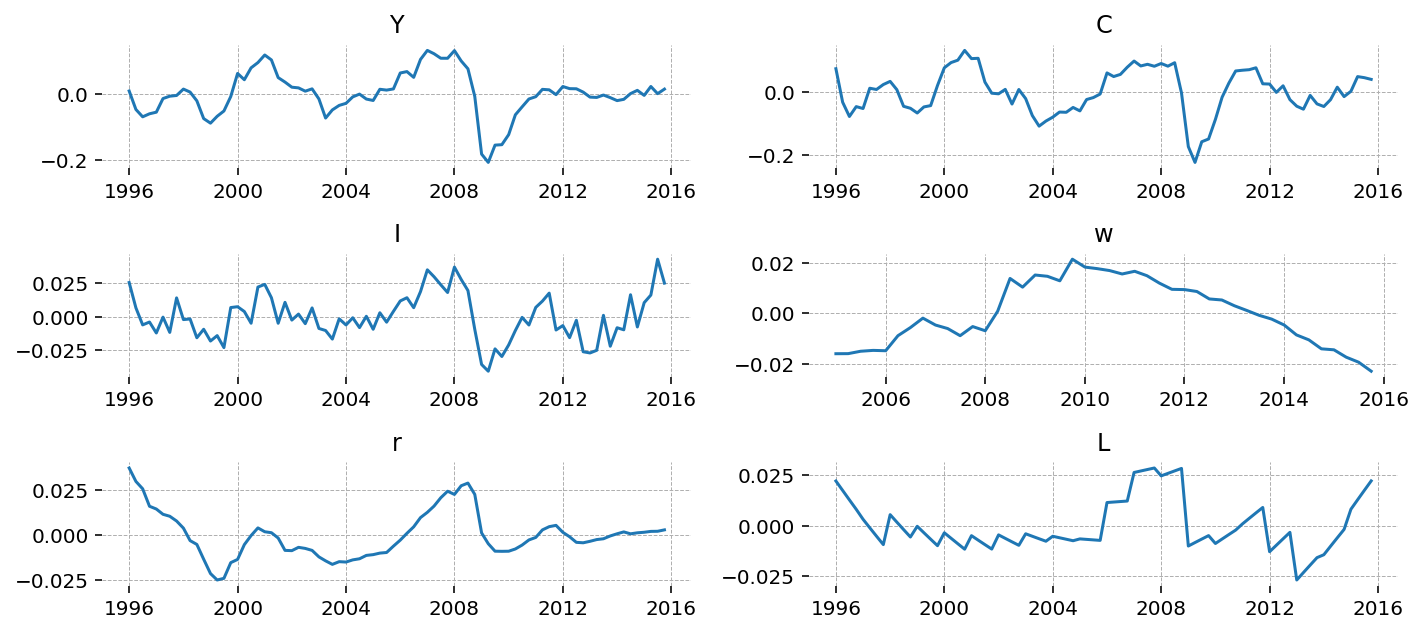

In [23]:
plot_df(_train)

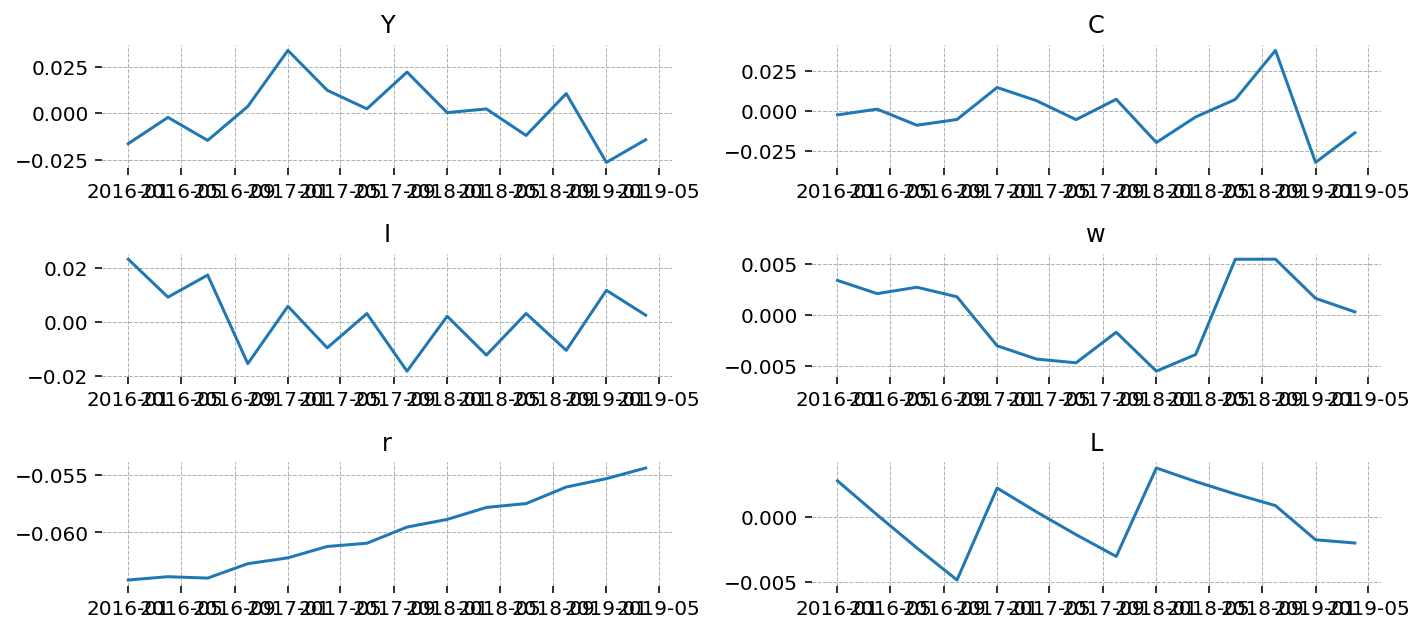

In [24]:
plot_df(_test)

In [25]:
### check stationarity
ADF_test_summary(_train.drop('w', axis=1), missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.244         -4.196        0.005          3    -4.083      -3.470     -3.162
	Constant             0.003          0.438        0.663
	Trend               -0.000         -0.341        0.734
Constant Only               -0.180         -3.550        0.007          1    -3.517      -2.899     -2.587
	Constant             0.001          0.237        0.813
No Constant                 -0.180         -3.573        0.000          1    -2.595      -1.945     -1.614
                                                      I                                                       
Specification               Coeff          Statistic     P-value      La

#### HP Filter <a class="anchor" id="subsection_2"></a>

In [26]:
for col in glob_cols:
    _train[col] = get_seasonal_hp(train[col], lamb=6.25, skipna=True)
    _test[col] = get_seasonal_hp(test[col], lamb=6.25, skipna=True)

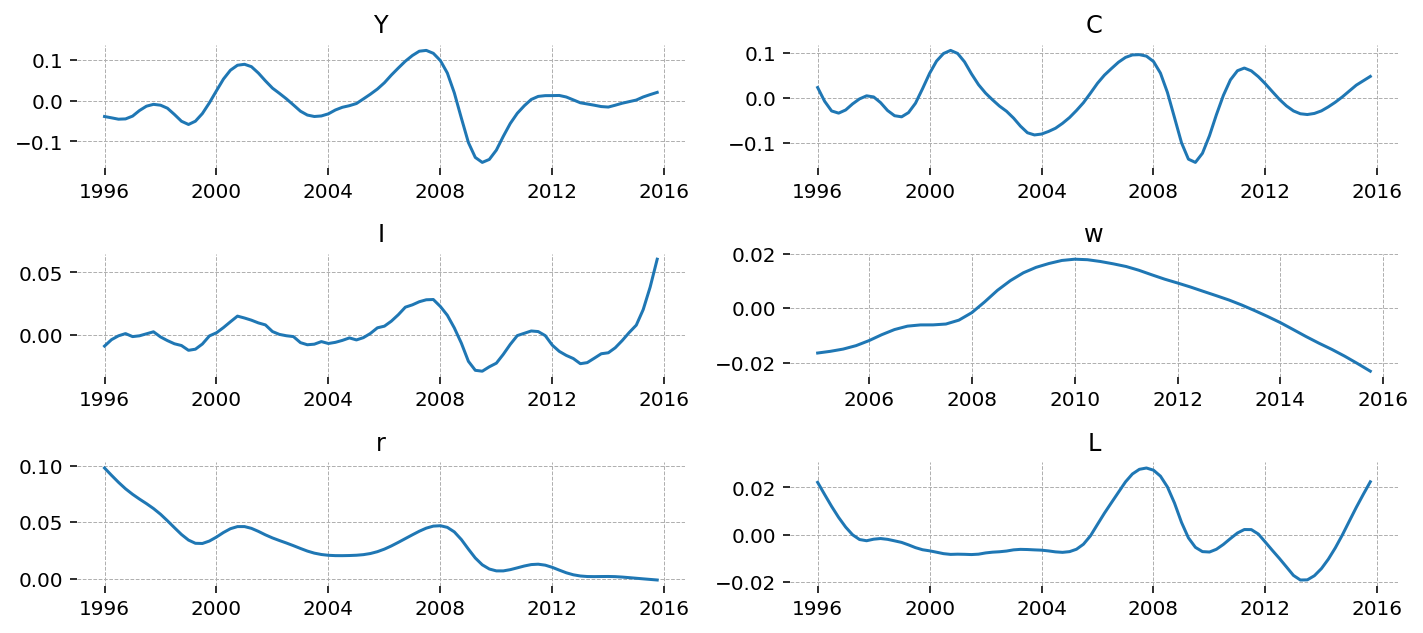

In [27]:
plot_df(_train)

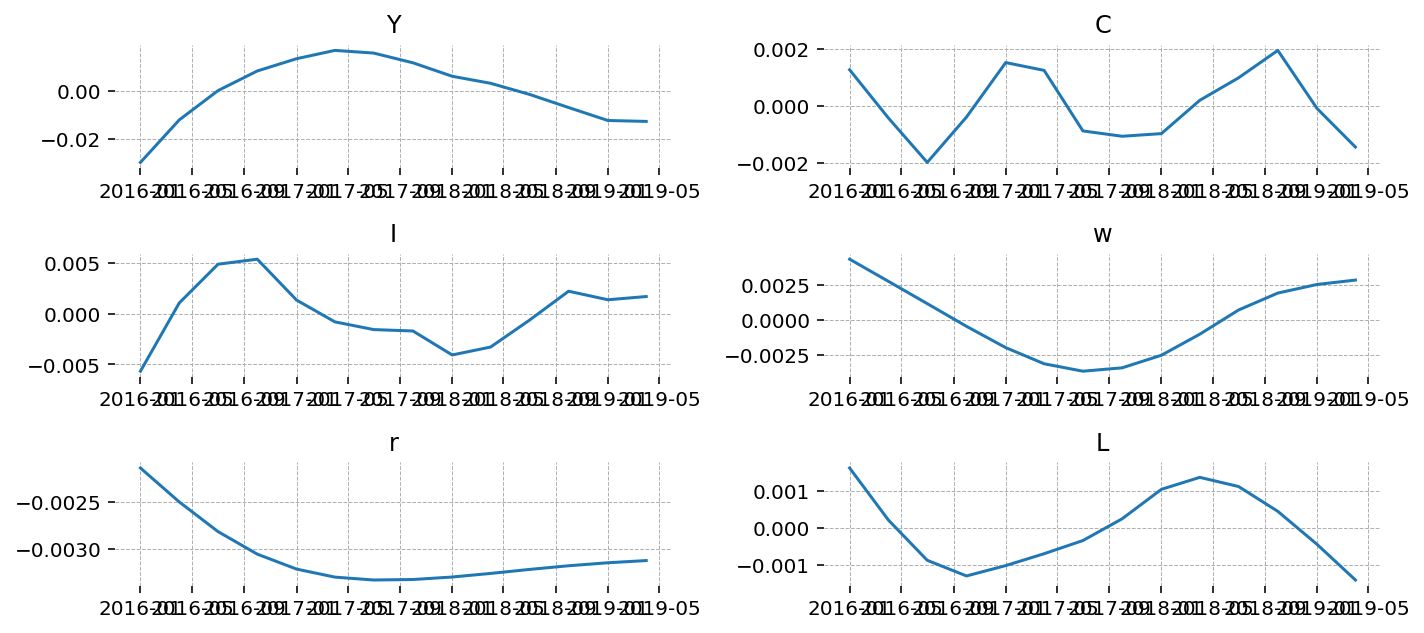

In [28]:
plot_df(_test)

In [29]:
### check stationarity
# 'no constant' is the p-val of interest
ADF_test_summary(_train.drop('w', axis=1), missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.034         -3.029        0.124          8    -4.092      -3.474     -3.164
	Constant             0.001          0.818        0.416
	Trend               -0.000         -0.605        0.548
Constant Only               -0.033         -2.989        0.036          8    -3.526      -2.903     -2.589
	Constant             0.000          0.598        0.552
No Constant                 -0.032         -2.971        0.003          8    -2.598      -1.945     -1.614
                                                      I                                                       
Specification               Coeff          Statistic     P-value      La

We will use the HP filter in the next sections. The OLS regression, a more naive approach produces similar results, but the HP filter smoothes better the data and its the most common tools in that kind of applications.

In [30]:
train = _train.copy()
test = _test.copy()

# RBC Model <a class="anchor" id="chapter3"></a>

In [32]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc_basic.gnc'))

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	6 parameters
		 0 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations <a class="anchor" id="section_3_1"></a>

In [33]:
for equation in rbc.system_equations:
    display(equation)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 + lambda_t+1*(1 - delta)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve the Model <a class="anchor" id="section_3_2"></a>

In [34]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 1.47501368398038e-19
Solution found, sum of squared residuals:  5.296102633836456e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [34]:
rbc.print_steady_state()

A_ss               1.000
C_ss               6.790
I_ss               1.018
K_ss             101.771
L_ss               3.138
Y_ss               7.808
lambda_ss          0.987
r_ss               0.020
w_ss               1.836


## Check Blanchard Kahn Conditions <a class="anchor" id="section_3_3"></a>

As we know from theory the Blanchard condition are important because they let us understand if the model has a unique solution through the steady state.

In [35]:
rbc.check_bk_condition()

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


Modulus          Real  Imaginary
0  7.125387e-31 -7.125387e-31       -0.0
1  4.145026e-19 -4.145026e-19       -0.0
2  1.654782e-17  1.654782e-17        0.0
3  2.750983e-17  2.750983e-17        0.0
4  5.917828e-17  5.917828e-17        0.0
5  7.395453e-01  7.395453e-01        0.0
6  9.405000e-01  9.405000e-01        0.0
7  1.365841e+00  1.365841e+00        0.0
8  4.696784e+06  4.696784e+06        0.0

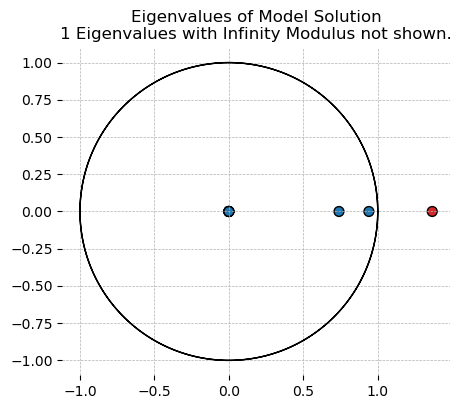

In [36]:
gp.plot_eigenvalues(rbc);

In [37]:
#Run IRFs with our starting parameters to compare with the estimated parameters at the end.
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

As we can see the output the number of unstable variables is the same as the number of control variable as a consequence the system has a unique solution.

# Maximum Likelihood Estimation <a class="anchor" id="chapter4"></a>

In [38]:
# assign date freq
train = train.asfreq("QS")
train.head()

Y         I         r         C   w         L
TIME                                                            
1996-01-01 -0.038572 -0.008759  0.097885  0.022497 NaN  0.022162
1996-04-01 -0.041820 -0.003640  0.091451 -0.007947 NaN  0.017030
1996-07-01 -0.045196 -0.000573  0.085275 -0.029443 NaN  0.012016
1996-10-01 -0.044496  0.001199  0.079549 -0.034302 NaN  0.007327
1997-01-01 -0.037604 -0.001199  0.074687 -0.027251 NaN  0.003230

## Simple model <a class="anchor" id="section_4_1"></a>

In [44]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [45]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
rbc.free_param_dict.update(calibrated_params)

In [46]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
#     'Y':0.01,
#     'C':0.02,
#     'L':0.05,
#     'I':0.02,
#     'r':0.03,
#     'w':0.1
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
#     'sigma_C': IntervalTransformer(low=1.05, high=10.0, slope=1),
#     'sigma_L': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
    'alpha':IntervalTransformer(low=0.0001, high=0.99, slope=1)
}

mle_mod = MLEModel(train[["Y"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [49]:
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=100)

basinhopping step 0: f -2.35714
basinhopping step 1: f -2.39672 trial_f -2.39672 accepted 1  lowest_f -2.39672
found new global minimum on step 1 with function value -2.39672
basinhopping step 2: f -2.40509 trial_f -2.40509 accepted 1  lowest_f -2.40509
found new global minimum on step 2 with function value -2.40509
basinhopping step 3: f -2.38931 trial_f -2.38931 accepted 1  lowest_f -2.40509
basinhopping step 4: f -2.39179 trial_f -2.39179 accepted 1  lowest_f -2.40509
basinhopping step 5: f -2.34781 trial_f -2.34781 accepted 1  lowest_f -2.40509
basinhopping step 6: f -2.35417 trial_f -2.35417 accepted 1  lowest_f -2.40509
basinhopping step 7: f -2.34384 trial_f -2.34384 accepted 1  lowest_f -2.40509
basinhopping step 8: f -2.31007 trial_f -2.31007 accepted 1  lowest_f -2.40509
basinhopping step 9: f -2.28358 trial_f -2.28358 accepted 1  lowest_f -2.40509
basinhopping step 10: f -2.29865 trial_f -2.29865 accepted 1  lowest_f -2.40509
basinhopping step 11: f -2.29837 trial_f -2.29837

basinhopping step 67: f -2.14547 trial_f -2.14547 accepted 1  lowest_f -2.40509
basinhopping step 68: f -2.14195 trial_f -2.14195 accepted 1  lowest_f -2.40509
basinhopping step 69: f -2.1403 trial_f -2.1403 accepted 1  lowest_f -2.40509
basinhopping step 70: f -2.07538 trial_f -2.07538 accepted 1  lowest_f -2.40509
basinhopping step 71: f -2.14058 trial_f -2.14058 accepted 1  lowest_f -2.40509
basinhopping step 72: f -2.15247 trial_f -2.15247 accepted 1  lowest_f -2.40509
basinhopping step 73: f -2.14126 trial_f -2.14126 accepted 1  lowest_f -2.40509
basinhopping step 74: f -2.15187 trial_f -2.15187 accepted 1  lowest_f -2.40509
basinhopping step 75: f -2.13833 trial_f -2.13833 accepted 1  lowest_f -2.40509
basinhopping step 76: f -2.0848 trial_f -2.0848 accepted 1  lowest_f -2.40509
basinhopping step 77: f -2.11252 trial_f -2.11252 accepted 1  lowest_f -2.40509
basinhopping step 78: f -2.11231 trial_f -2.11231 accepted 1  lowest_f -2.40509
basinhopping step 79: f -2.11231 trial_f -2.

In [50]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                  50.754
Date:                Thu, 08 Dec 2022   AIC                            -97.508
Time:                        13:51:30   BIC                            -92.744
Sample:                    01-01-1996   HQIC                           -95.598
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.8453      0.234      3.614      0.000       0.387       1.304
sigma2.epsilon_A     0.0110      0.003      4.256      0.000       0.006       0.016
===================================================================================
Ljung-Box (L1) (Q):                  67.91   Jarque-Bera (JB):                39.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.17
Prob(H) (two-sided):                  0.69   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

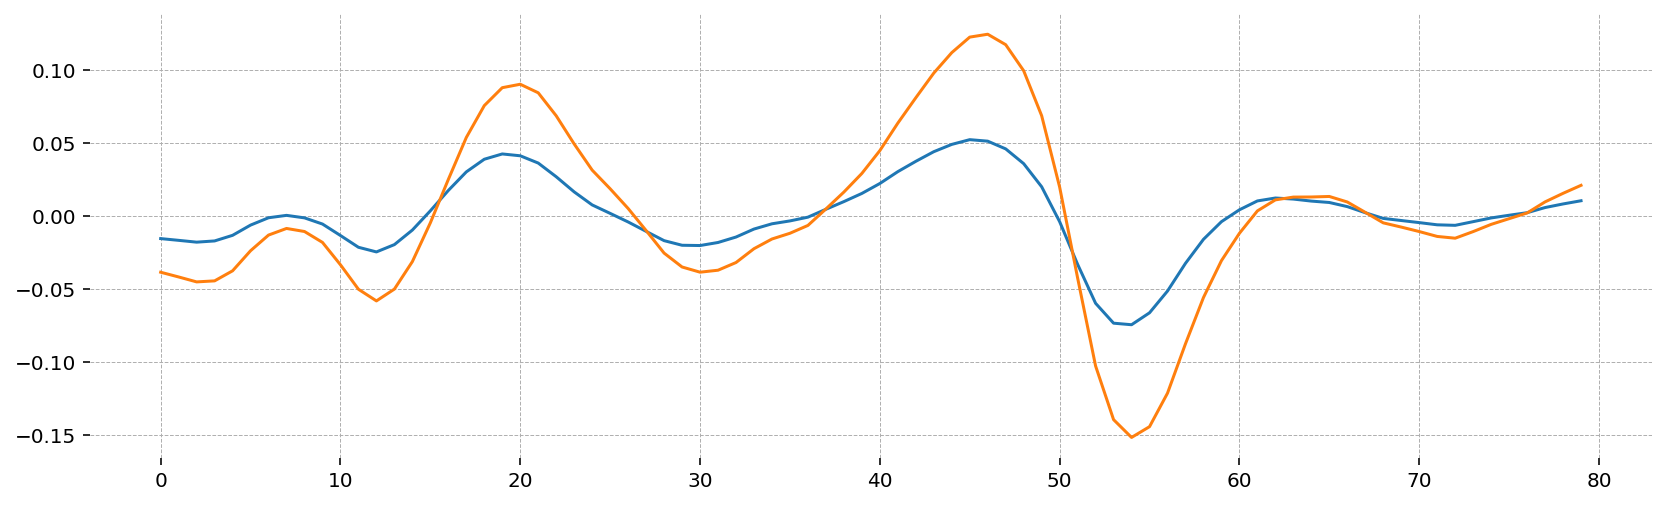

In [52]:
# without any observation noise the 'filter' output should equal the data, why not the case ??
plt.plot(mle_res.filtered_state[0])
plt.plot(train.Y.values)

As we can see our model follows the variation of the data, even though they are smoothed. 

### MLE Kalman Filter Prediction Plots <a class="anchor" id="subsection_4_1"></a>

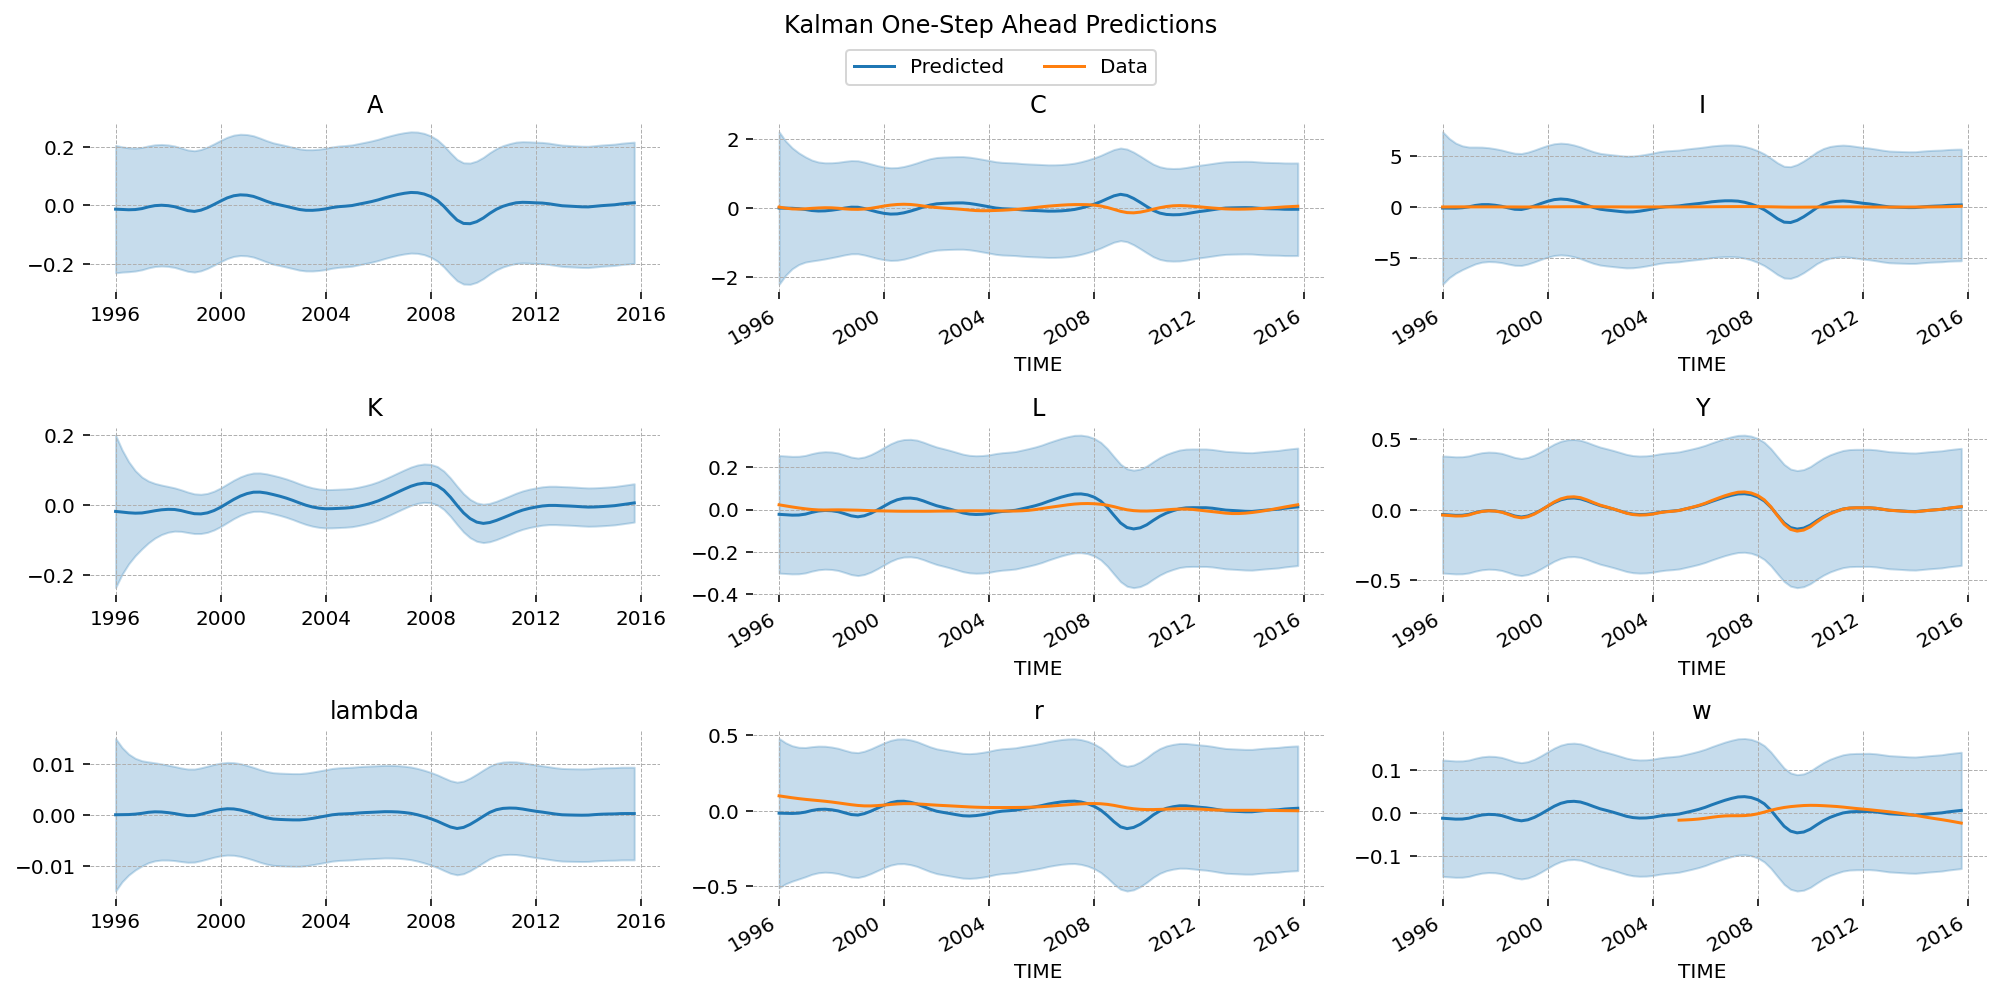

In [53]:
plot_sm_results(mle_res, train, var_names=plot_vars)

The model does not pick-up on much variation in the data. Confidence intervals are rather broad and predicted variations seem random. In magnitude deviations go far beyond the actual data, suggesting that the model has not capture the variance correctly.

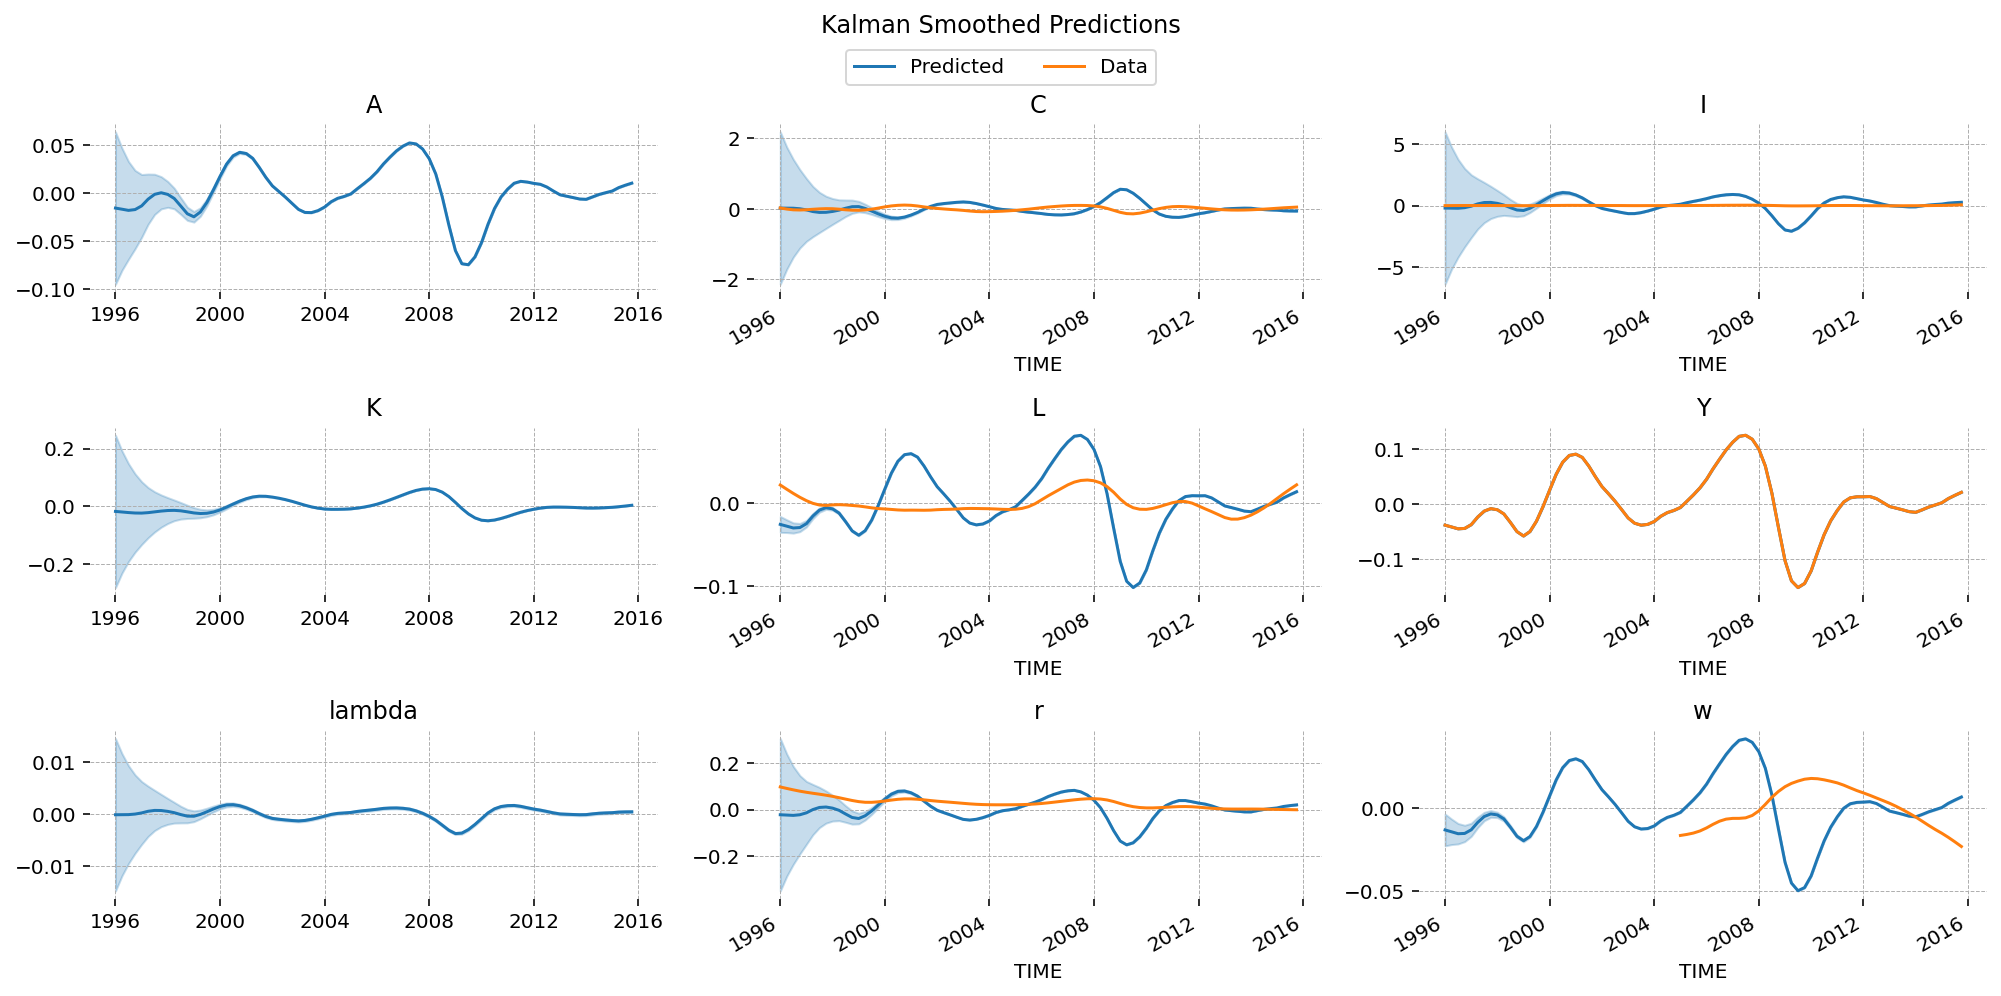

In [54]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

The majority of the problem can be seen in the prediction of the Great Recession of 2009. This is due to the fact that in the RBC model, economic crisis are not properly include. In fact the model considers only shocks in the production, considered as errors. 

### Forecasting <a class="anchor" id="subsection_4_2"></a>

In [55]:
mle_forecast = mle_res.get_forecast(steps=test_size)

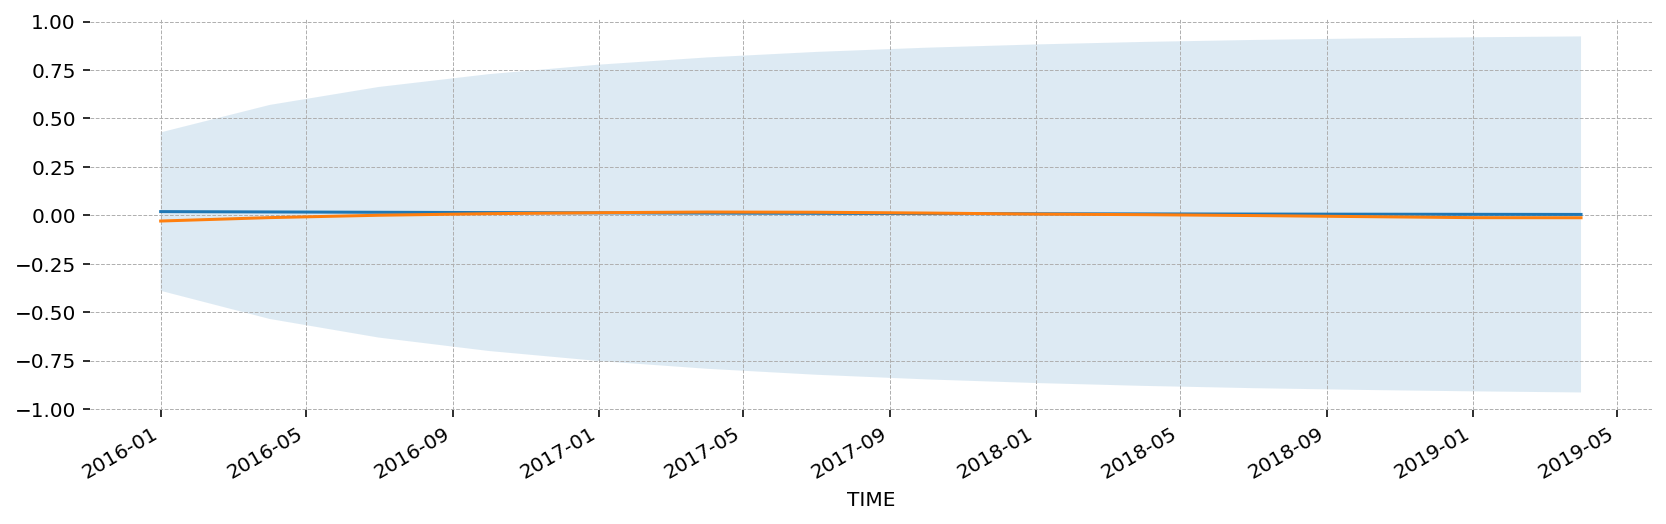

In [56]:
mu = mle_forecast.predicted_mean

# var_pred_mean is the variance, but the 95% CI will be +/- 1.96 * std, so we have to take square root.
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean)

fig, ax = plt.subplots()
ax.plot(mu)
ax.fill_between(mu.index, mu - sigma, mu + sigma, alpha=0.15)
test.Y.plot(ax=ax)
plt.show()

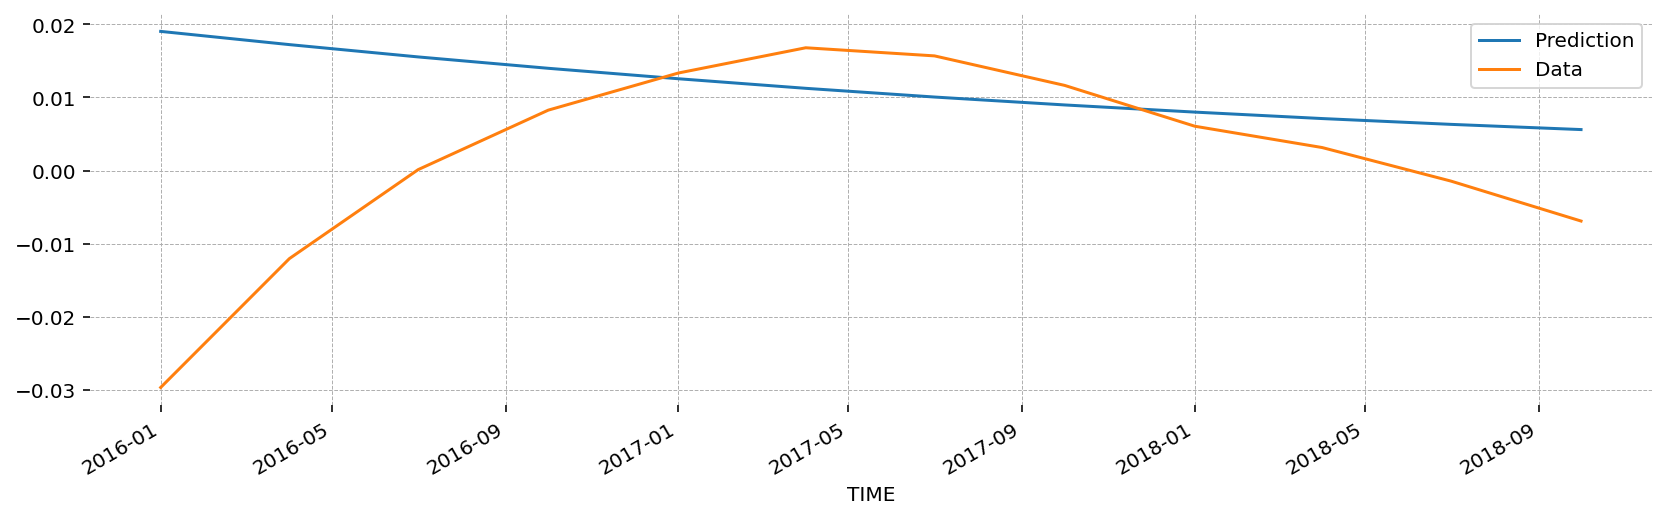

In [57]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

Our model has not correctly captured the notion of an overbooming economy, that evenutally declines. This could be an interpretation of the down-turn in 2017, which has been preceeded by years of recovery and subsquent boom of post 08.

## A noisy model <a class="anchor" id="section_4_2"></a>

In [58]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [59]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
rbc.free_param_dict.update(calibrated_params)

In [60]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
    'Y':0.01,
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
#     'alpha':IntervalTransformer(low=0.0001, high=0.99, slope=1)
}

mle_mod = MLEModel(train[["Y"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [63]:
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=100)

basinhopping step 0: f -2.36222
basinhopping step 1: f -2.32031 trial_f -2.32031 accepted 1  lowest_f -2.36222
basinhopping step 2: f -2.37471 trial_f -2.37471 accepted 1  lowest_f -2.37471
found new global minimum on step 2 with function value -2.37471
basinhopping step 3: f -2.33385 trial_f -2.33385 accepted 1  lowest_f -2.37471
basinhopping step 4: f -2.34688 trial_f -2.34688 accepted 1  lowest_f -2.37471
basinhopping step 5: f -2.37571 trial_f -2.37571 accepted 1  lowest_f -2.37571
found new global minimum on step 5 with function value -2.37571
basinhopping step 6: f -1.74481 trial_f -1.74481 accepted 1  lowest_f -2.37571
basinhopping step 7: f -2.35087 trial_f -2.35087 accepted 1  lowest_f -2.37571
basinhopping step 8: f -2.36399 trial_f -2.36399 accepted 1  lowest_f -2.37571
basinhopping step 9: f -2.42832 trial_f -2.42832 accepted 1  lowest_f -2.42832
found new global minimum on step 9 with function value -2.42832
basinhopping step 10: f -2.30782 trial_f -2.30782 accepted 1  low

basinhopping step 64: f -2.29117 trial_f -2.29117 accepted 1  lowest_f -2.43958
basinhopping step 65: f -2.25255 trial_f -2.25255 accepted 1  lowest_f -2.43958
basinhopping step 66: f -1.42273 trial_f -1.42273 accepted 1  lowest_f -2.43958
basinhopping step 67: f -2.27807 trial_f -2.27807 accepted 1  lowest_f -2.43958
basinhopping step 68: f -2.32586 trial_f -2.32586 accepted 1  lowest_f -2.43958
basinhopping step 69: f -2.32586 trial_f -1.48867 accepted 0  lowest_f -2.43958
basinhopping step 70: f -2.32163 trial_f -2.32163 accepted 1  lowest_f -2.43958
basinhopping step 71: f -2.31613 trial_f -2.31613 accepted 1  lowest_f -2.43958
basinhopping step 72: f -2.31613 trial_f -1.60061 accepted 0  lowest_f -2.43958
basinhopping step 73: f -2.31613 trial_f -2.24518 accepted 0  lowest_f -2.43958
basinhopping step 74: f -1.48002 trial_f -1.48002 accepted 1  lowest_f -2.43958
basinhopping step 75: f -2.30304 trial_f -2.30304 accepted 1  lowest_f -2.43958
basinhopping step 76: f -2.35567 trial_f

In [64]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                  48.461
Date:                Thu, 08 Dec 2022   AIC                            -90.923
Time:                        13:59:13   BIC                            -83.777
Sample:                    01-01-1996   HQIC                           -88.058
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9567      0.629      1.520      0.128      -0.277       2.190
sigma2.epsilon_A     0.0105      0.202      0.052      0.958      -0.385       0.406
sigma2.Y             0.0011      0.391      0.003      0.998      -0.765       0.767
===================================================================================
Ljung-Box (L1) (Q):                  67.10   Jarque-Bera (JB):                29.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.98
Prob(H) (two-sided):                  0.97   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

Estimated variance of Y is very close to zero, the data seems trustworthy

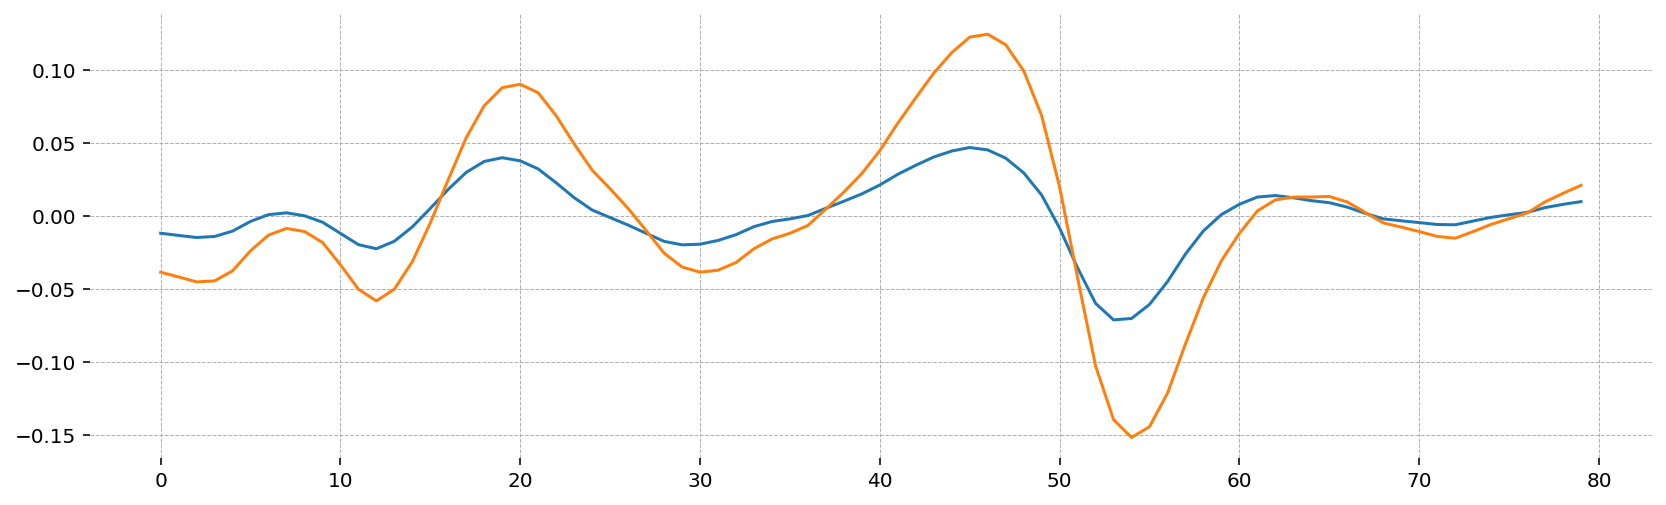

In [65]:
plt.plot(mle_res.filtered_state[0])
plt.plot(train.Y.values)

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_3"></a>

Predictions

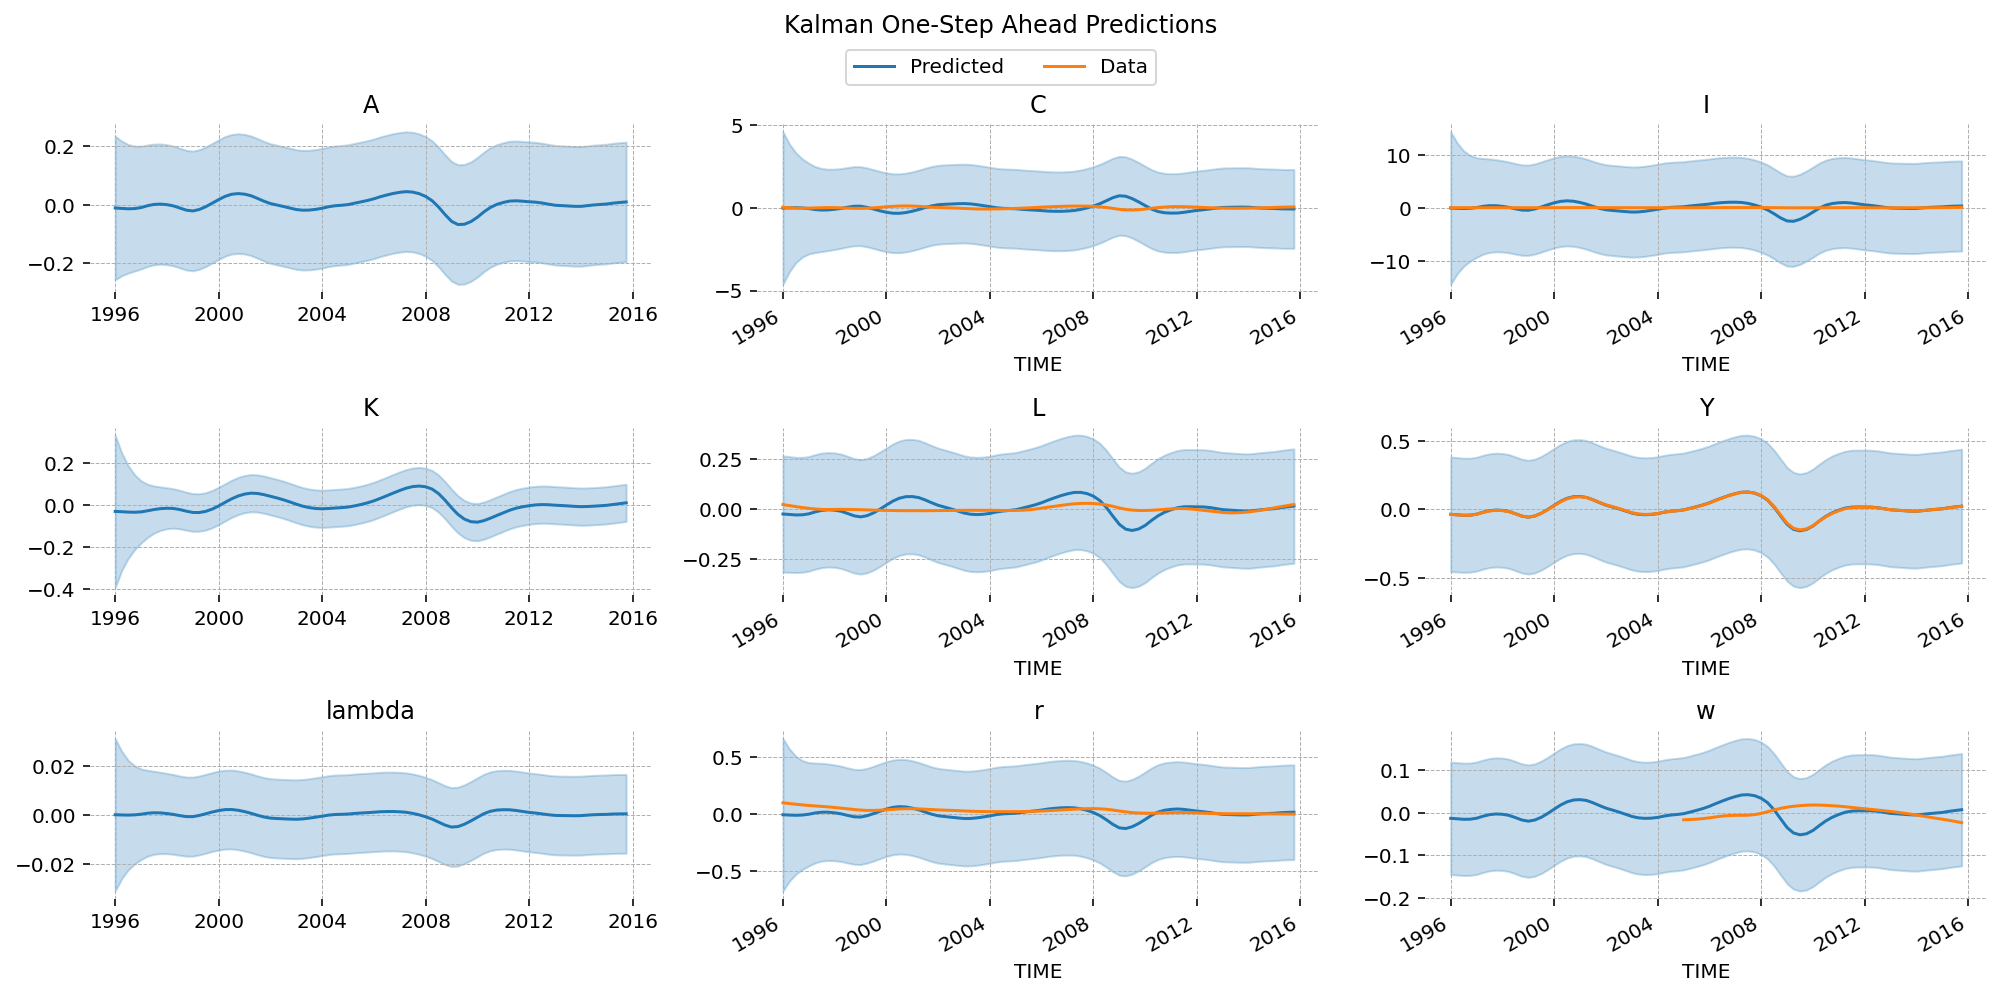

In [66]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

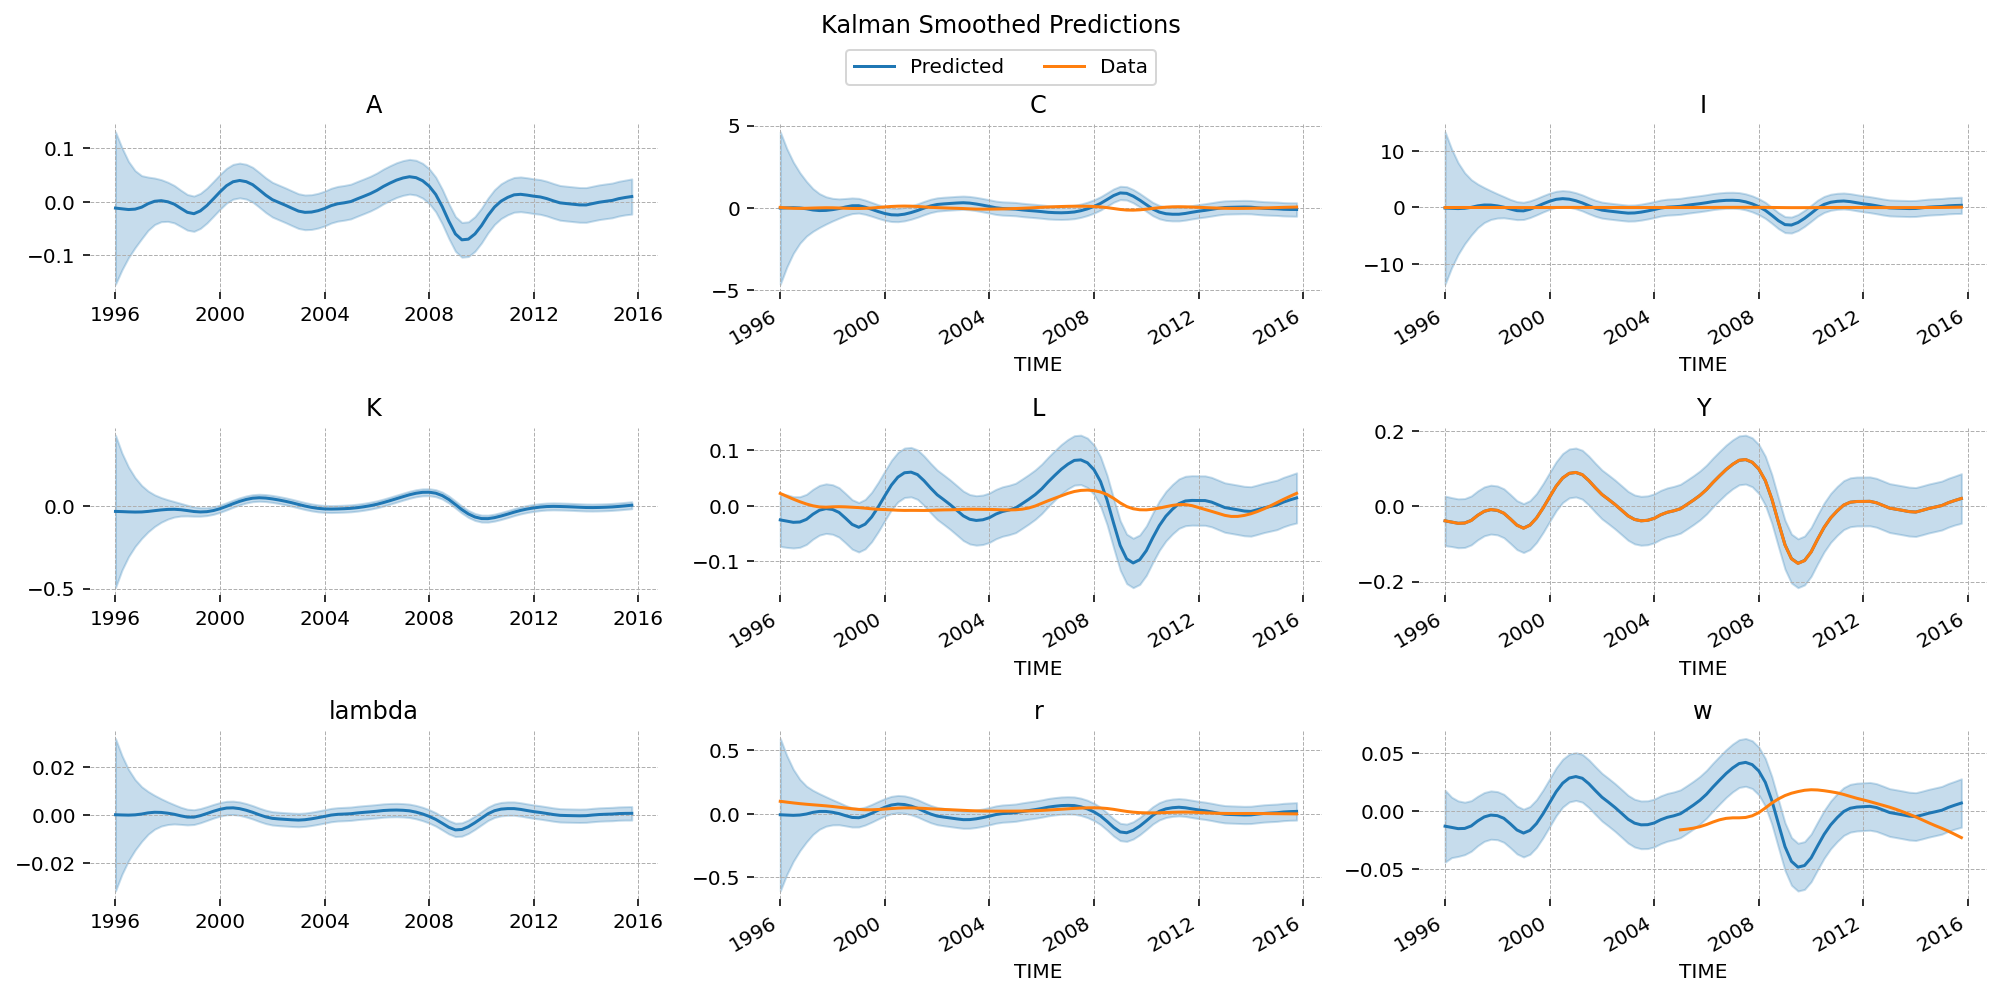

In [67]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="section_4_4"></a>

In [68]:
mle_forecast = mle_res.get_forecast(steps=test_size)

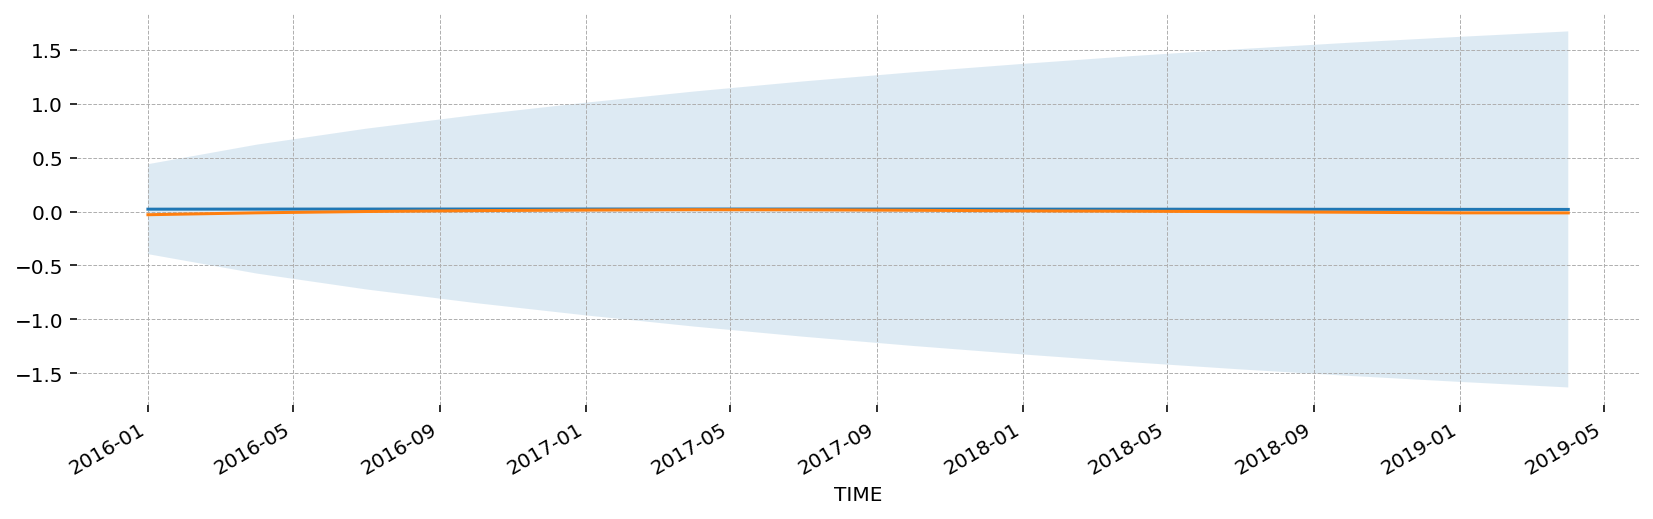

In [69]:
mu = mle_forecast.predicted_mean

# var_pred_mean is the variance, but the 95% CI will be +/- 1.96 * std, so we have to take square root.
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean)

fig, ax = plt.subplots()
ax.plot(mu)
ax.fill_between(mu.index, mu - sigma, mu + sigma, alpha=0.15)
test.Y.plot(ax=ax)
plt.show()

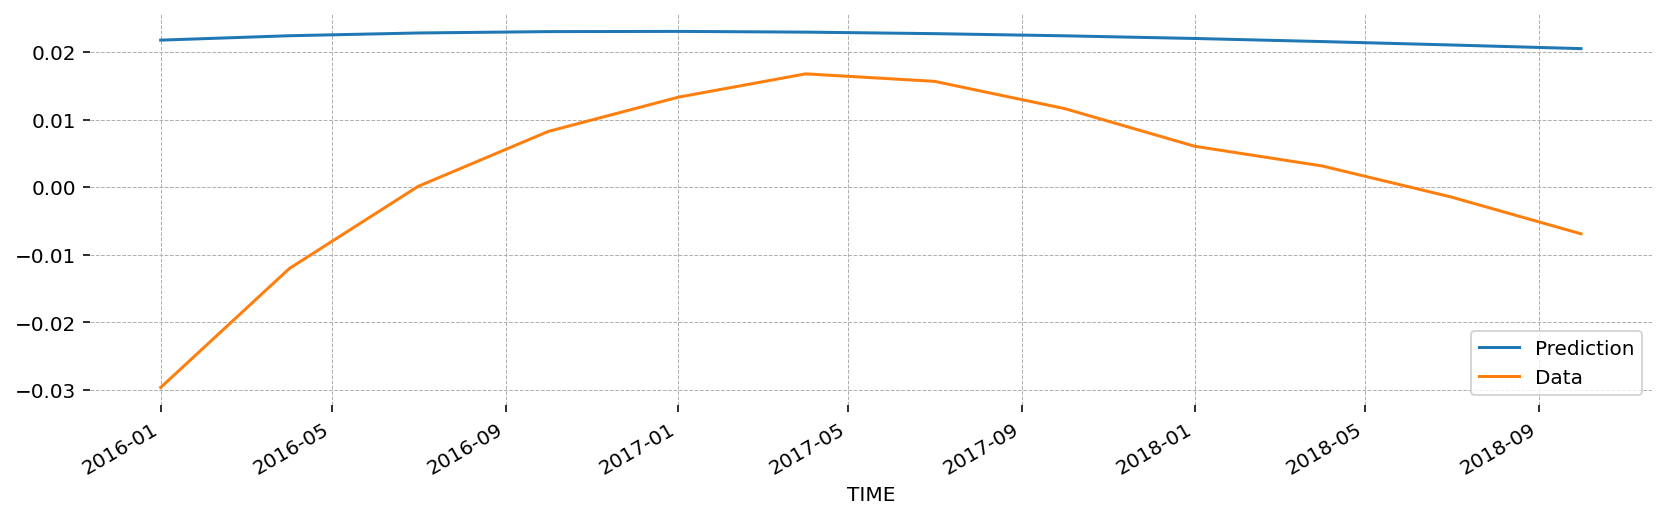

In [70]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## Adding variables  <a class="anchor" id="section_4_3"></a>

In [71]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [72]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
rbc.free_param_dict.update(calibrated_params)

In [73]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85,
    'sigma_C': 0,
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
    'Y':0.01,
#     'L': 0.05
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'sigma_C': IntervalTransformer(low=0, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
}

mle_mod = MLEModel(train[["Y", 'L']],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [74]:
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=100)

basinhopping step 0: f -4.45525
basinhopping step 1: f -3.81281 trial_f -3.81281 accepted 1  lowest_f -4.45525
basinhopping step 2: f -5.31914 trial_f -5.31914 accepted 1  lowest_f -5.31914
found new global minimum on step 2 with function value -5.31914
basinhopping step 3: f -5.31914 trial_f -3.71739 accepted 0  lowest_f -5.31914
basinhopping step 4: f -5.31914 trial_f -4.22591 accepted 0  lowest_f -5.31914
basinhopping step 5: f -4.95813 trial_f -4.95813 accepted 1  lowest_f -5.31914
basinhopping step 6: f -4.818 trial_f -4.818 accepted 1  lowest_f -5.31914
basinhopping step 7: f -3.75638 trial_f -3.75638 accepted 1  lowest_f -5.31914
basinhopping step 8: f -3.75638 trial_f -2.4969 accepted 0  lowest_f -5.31914
basinhopping step 9: f -4.41977 trial_f -4.41977 accepted 1  lowest_f -5.31914
basinhopping step 10: f -4.97944 trial_f -4.97944 accepted 1  lowest_f -5.31914
basinhopping step 11: f -5.2238 trial_f -5.2238 accepted 1  lowest_f -5.31914
basinhopping step 12: f -5.2238 trial_f 

basinhopping step 66: f -5.35058 trial_f -5.35058 accepted 1  lowest_f -5.39611
basinhopping step 67: f -5.35058 trial_f -4.81892 accepted 0  lowest_f -5.39611
basinhopping step 68: f -5.23655 trial_f -5.23655 accepted 1  lowest_f -5.39611
basinhopping step 69: f -5.23655 trial_f -3.07614 accepted 0  lowest_f -5.39611
basinhopping step 70: f -5.23655 trial_f -4.62887 accepted 0  lowest_f -5.39611
basinhopping step 71: f -4.60783 trial_f -4.60783 accepted 1  lowest_f -5.39611
basinhopping step 72: f -5.37214 trial_f -5.37214 accepted 1  lowest_f -5.39611
basinhopping step 73: f -4.56531 trial_f -4.56531 accepted 1  lowest_f -5.39611
basinhopping step 74: f -4.56531 trial_f -3.33344 accepted 0  lowest_f -5.39611
basinhopping step 75: f -4.56531 trial_f -2.9832 accepted 0  lowest_f -5.39611
basinhopping step 76: f -5.38316 trial_f -5.38316 accepted 1  lowest_f -5.39611
basinhopping step 77: f -4.83531 trial_f -4.83531 accepted 1  lowest_f -5.39611
basinhopping step 78: f -4.20039 trial_f 

In [75]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             ['Y', 'L']   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                 170.199
Date:                Thu, 08 Dec 2022   AIC                           -332.397
Time:                        14:03:15   BIC                           -322.869
Sample:                    01-01-1996   HQIC                          -328.577
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.7722      0.393      1.967      0.049       0.003       1.542
sigma_C           1.693e-08      0.000      0.000      1.000      -0.000       0.000
sigma2.epsilon_A     0.0036      0.010      0.369      0.712      -0.016       0.023
sigma2.Y             0.0559      0.159      0.351      0.726      -0.256       0.368
===================================================================================
Ljung-Box (L1) (Q):           74.83, 64.02   Jarque-Bera (JB):           3.26, 4.43
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.20, 0.11
Heteroskedasticity (H):         1.07, 0.77   Skew:                      -0.44, 0.49
Prob(H) (two-sided):            0.86, 0.49   Kurtosis:                   3.46, 3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

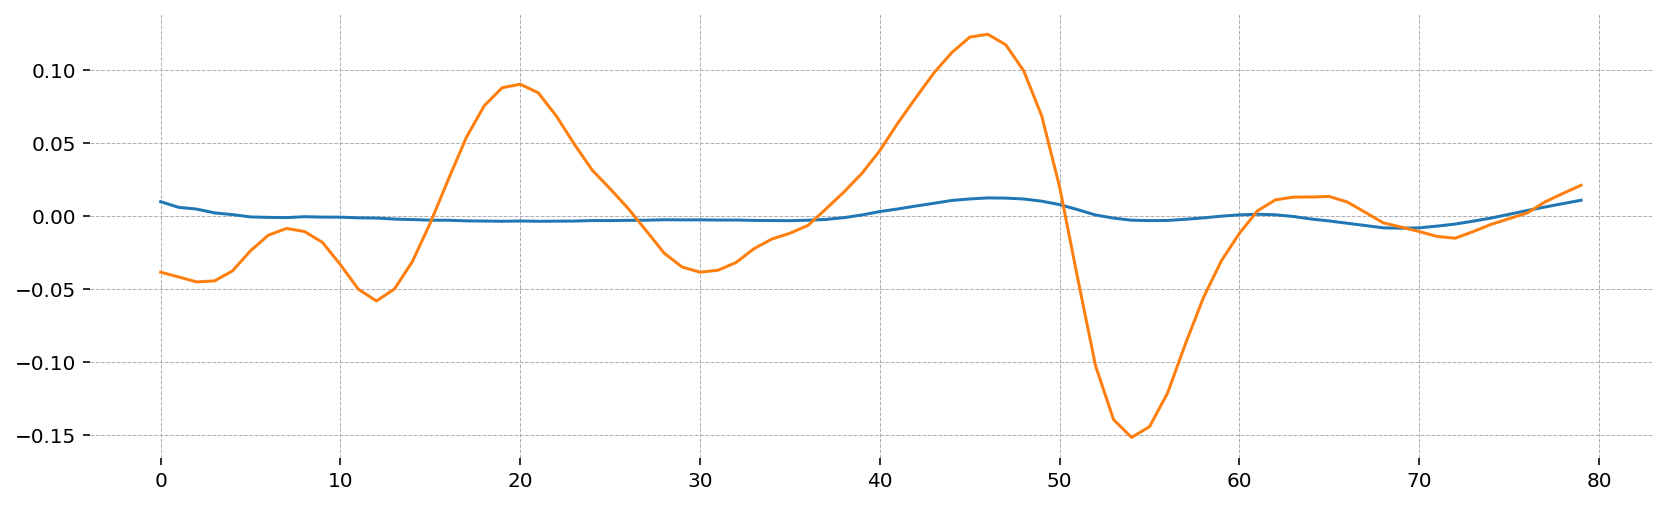

In [76]:
# without any observation noise the 'filter' output should equal the data, why not the case ??
plt.plot(mle_res.filtered_state[0])
plt.plot(train.Y.values)

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_5"></a>

Predictions

The model does not pick-up on much variation in the data. Confidence intervals are rather broad and predicted variations seem random. In magnitude deviations go far beyond the actual data, suggesting that the model has not capture the variance correctly.

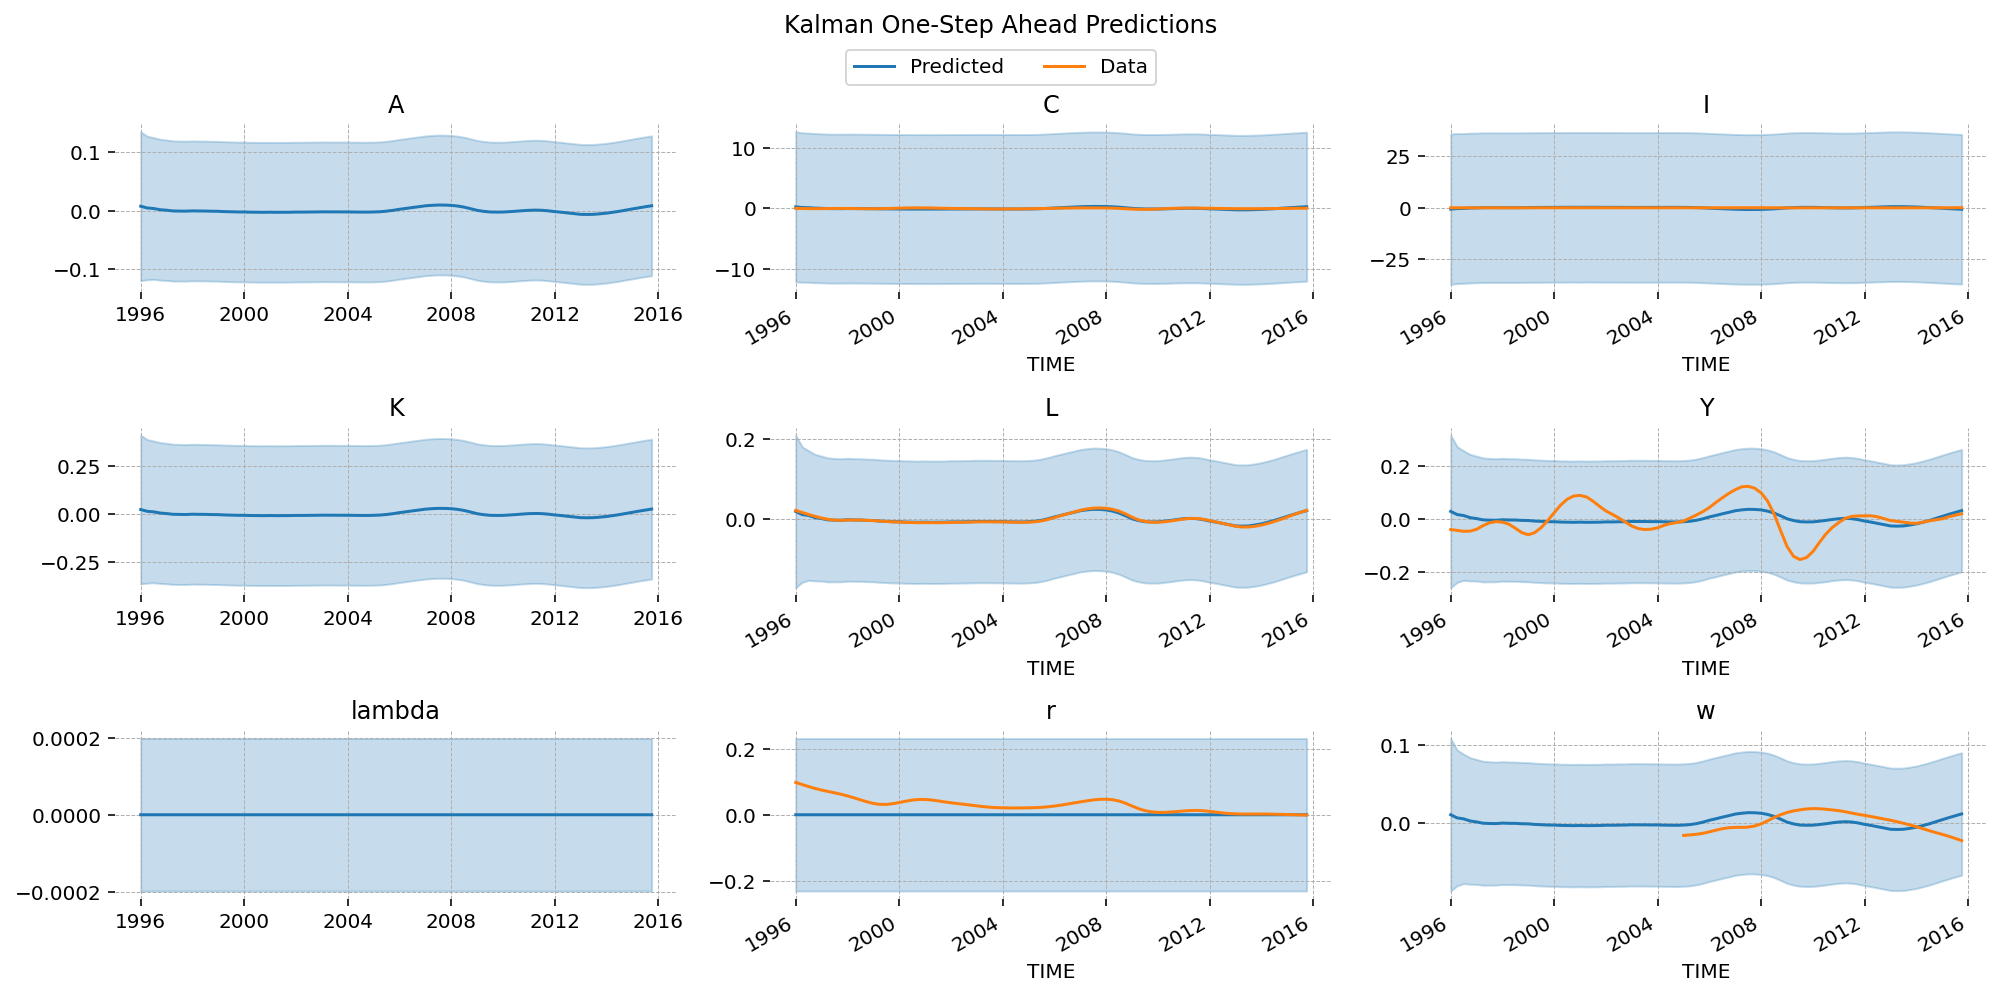

In [77]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

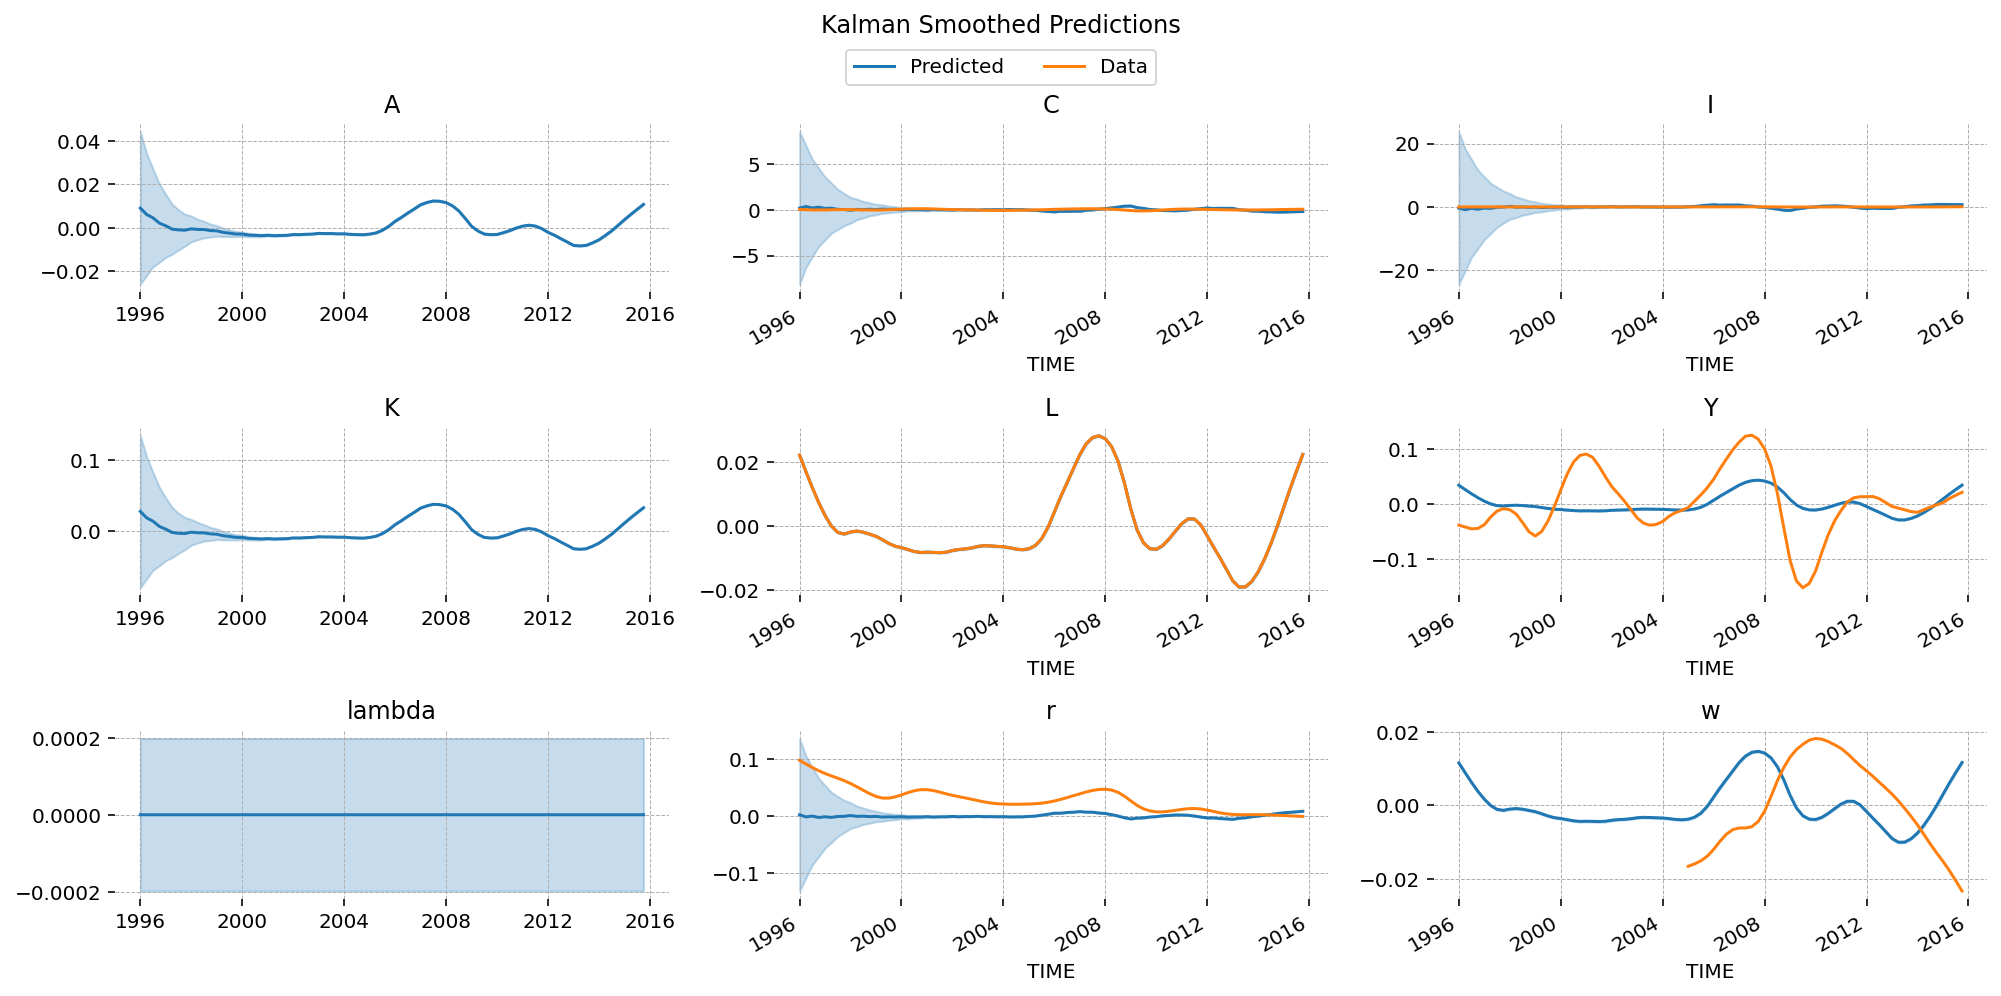

In [78]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_4_6"></a>

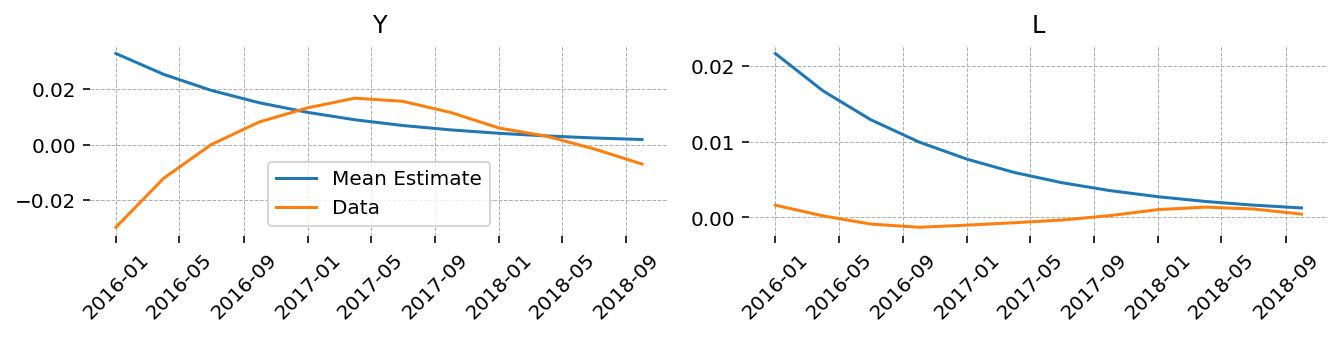

In [79]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'L'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

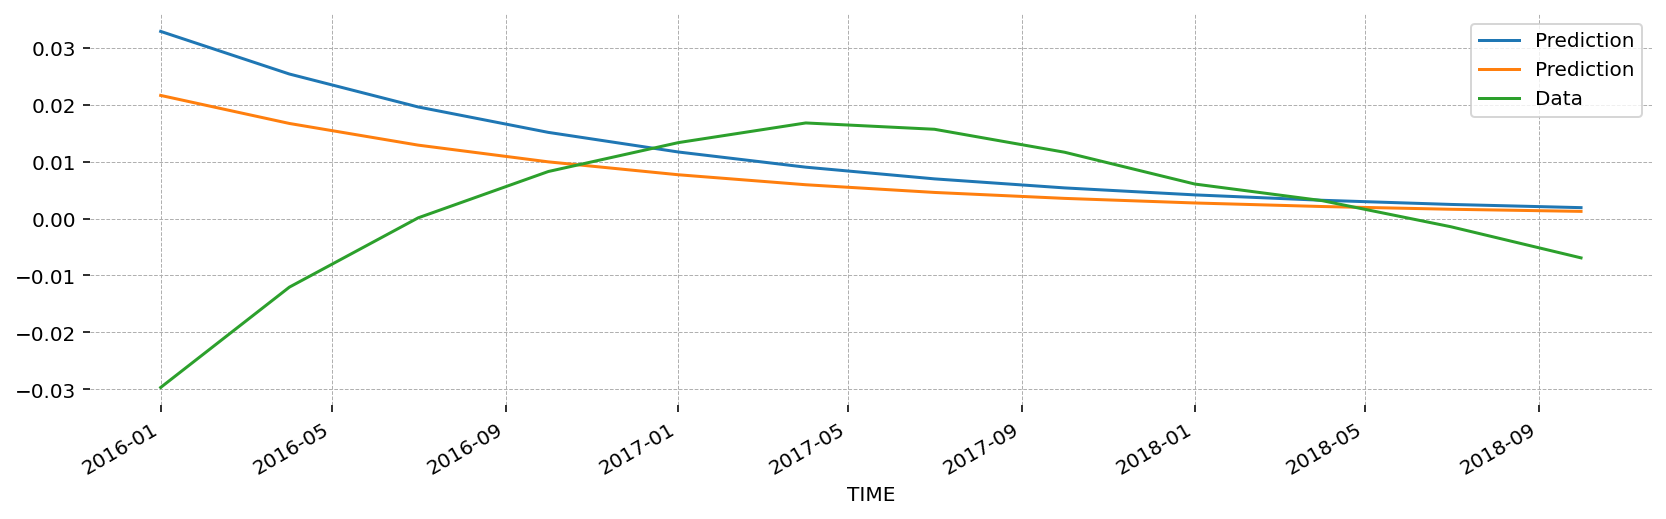

In [80]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## Final model <a class="anchor" id="section_4_4"></a>

In [106]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [107]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
rbc.free_param_dict.update(calibrated_params)

In [111]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85,
     'sigma_C': 0,
#     'sigma_L': .2,
#     'alpha': .1
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
     'Y':0.01,
#    'C':0.02,
#     'L':0.05,
#     'I':0.02,
#     'r':0.03,
#     'w':0.1
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
     'sigma_C': IntervalTransformer(low=0, high=3, slope=1),
#     'sigma_L': IntervalTransformer(low=0, high=4, slope=1),
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
#     'alpha':IntervalTransformer(low=0.0001, high=0.99, slope=1)
}

mle_mod = MLEModel(train[["Y", "L", "I"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [112]:
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=1)

basinhopping step 0: f 39.3245
basinhopping step 1: f 39.3245 trial_f 2890.19 accepted 0  lowest_f 39.3245
basinhopping step 2: f -0.404557 trial_f -0.404557 accepted 1  lowest_f -0.404557
found new global minimum on step 2 with function value -0.404557
basinhopping step 3: f -0.404557 trial_f 10.5109 accepted 0  lowest_f -0.404557
basinhopping step 4: f -0.239963 trial_f -0.239963 accepted 1  lowest_f -0.404557
basinhopping step 5: f -0.239963 trial_f 15.7635 accepted 0  lowest_f -0.404557
basinhopping step 6: f -0.239963 trial_f 1.20026e+08 accepted 0  lowest_f -0.404557
basinhopping step 7: f -0.239963 trial_f 53.7654 accepted 0  lowest_f -0.404557
basinhopping step 8: f -0.239963 trial_f 1.66369e+09 accepted 0  lowest_f -0.404557
basinhopping step 9: f -0.239963 trial_f 971.322 accepted 0  lowest_f -0.404557
basinhopping step 10: f -0.239963 trial_f 32.2385 accepted 0  lowest_f -0.404557
basinhopping step 11: f -0.239963 trial_f 49.4353 accepted 0  lowest_f -0.404557
basinhopping s

basinhopping step 65: f -3.31668 trial_f -2.06739 accepted 0  lowest_f -3.3851
basinhopping step 66: f -3.31668 trial_f 417.071 accepted 0  lowest_f -3.3851
basinhopping step 67: f -3.31668 trial_f 67.5214 accepted 0  lowest_f -3.3851
basinhopping step 68: f -3.31668 trial_f 42.396 accepted 0  lowest_f -3.3851
basinhopping step 69: f -3.30491 trial_f -3.30491 accepted 1  lowest_f -3.3851
basinhopping step 70: f -1.49857 trial_f -1.49857 accepted 1  lowest_f -3.3851
basinhopping step 71: f -1.49857 trial_f 0.541338 accepted 0  lowest_f -3.3851
basinhopping step 72: f -1.49857 trial_f 33.2386 accepted 0  lowest_f -3.3851
basinhopping step 73: f -0.68777 trial_f -0.68777 accepted 1  lowest_f -3.3851
basinhopping step 74: f -1.48205 trial_f -1.48205 accepted 1  lowest_f -3.3851
basinhopping step 75: f -1.48205 trial_f 29.941 accepted 0  lowest_f -3.3851
basinhopping step 76: f -1.48205 trial_f 53.9207 accepted 0  lowest_f -3.3851
basinhopping step 77: f -1.48205 trial_f 37.0737 accepted 0 

In [114]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:        ['Y', 'L', 'I']   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                 102.447
Date:                Thu, 08 Dec 2022   AIC                           -196.894
Time:                        15:39:48   BIC                           -187.366
Sample:                    01-01-1996   HQIC                          -193.074
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9585        nan        nan        nan         nan         nan
sigma_C           9.809e-09   4.05e-29   2.42e+20      0.000    9.81e-09    9.81e-09
sigma2.epsilon_A     0.0113   5.41e-16   2.09e+13      0.000       0.011       0.011
sigma2.Y             0.0868   3.57e-16   2.43e+14      0.000       0.087       0.087
=====================================================================================
Ljung-Box (L1) (Q):     72.96, 63.30, 0.00   Jarque-Bera (JB):   3.64, 2.60, 19783.17
Prob(Q):                  0.00, 0.00, 1.00   Prob(JB):               0.16, 0.27, 0.00
Heteroskedasticity (H):   1.04, 0.89, 0.00   Skew:                 -0.47, 0.41, -8.78
Prob(H) (two-sided):      0.93, 0.76, 0.00   Kurtosis:              3.46, 3.32, 78.01
=====================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+32. Standard errors may be unstable.
"""

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_7"></a>

Predictions

The model does not pick-up on much variation in the data. Confidence intervals are rather broad and predicted variations seem random. In magnitude deviations go far beyond the actual data, suggesting that the model has not capture the variance correctly.

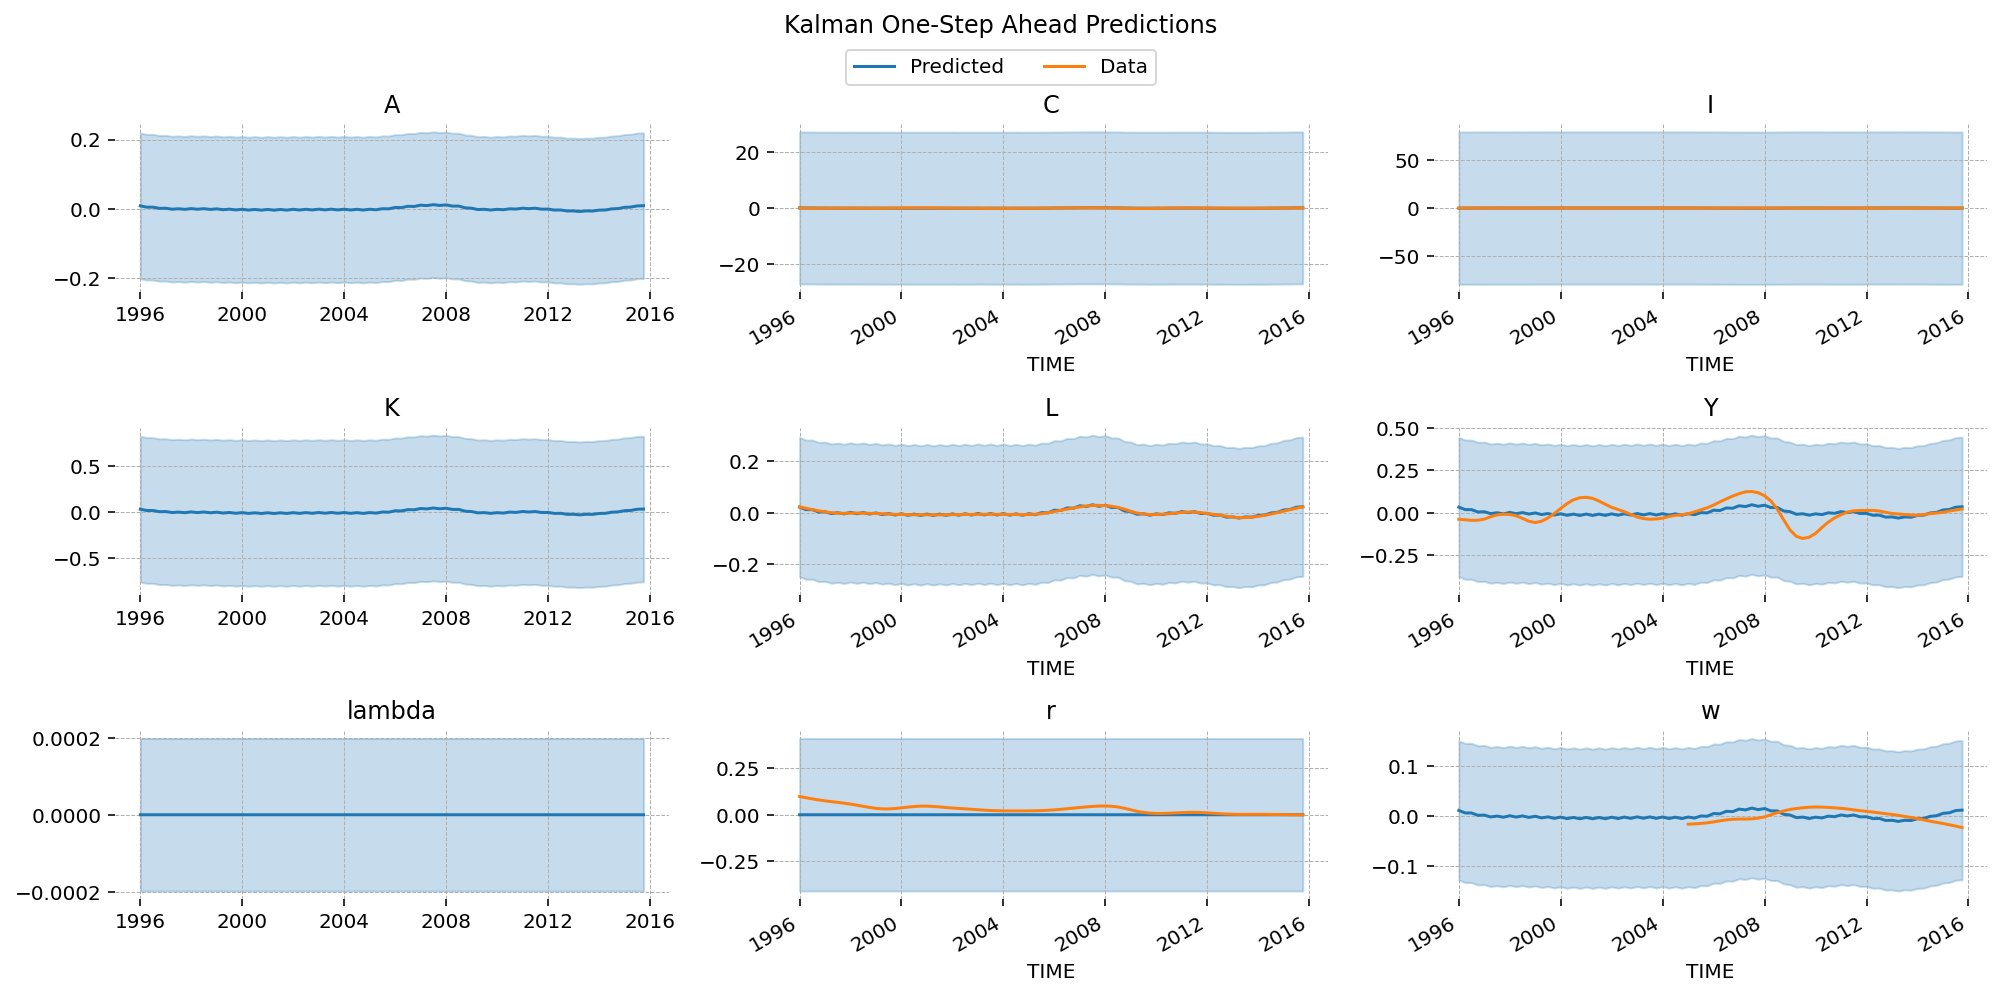

In [115]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

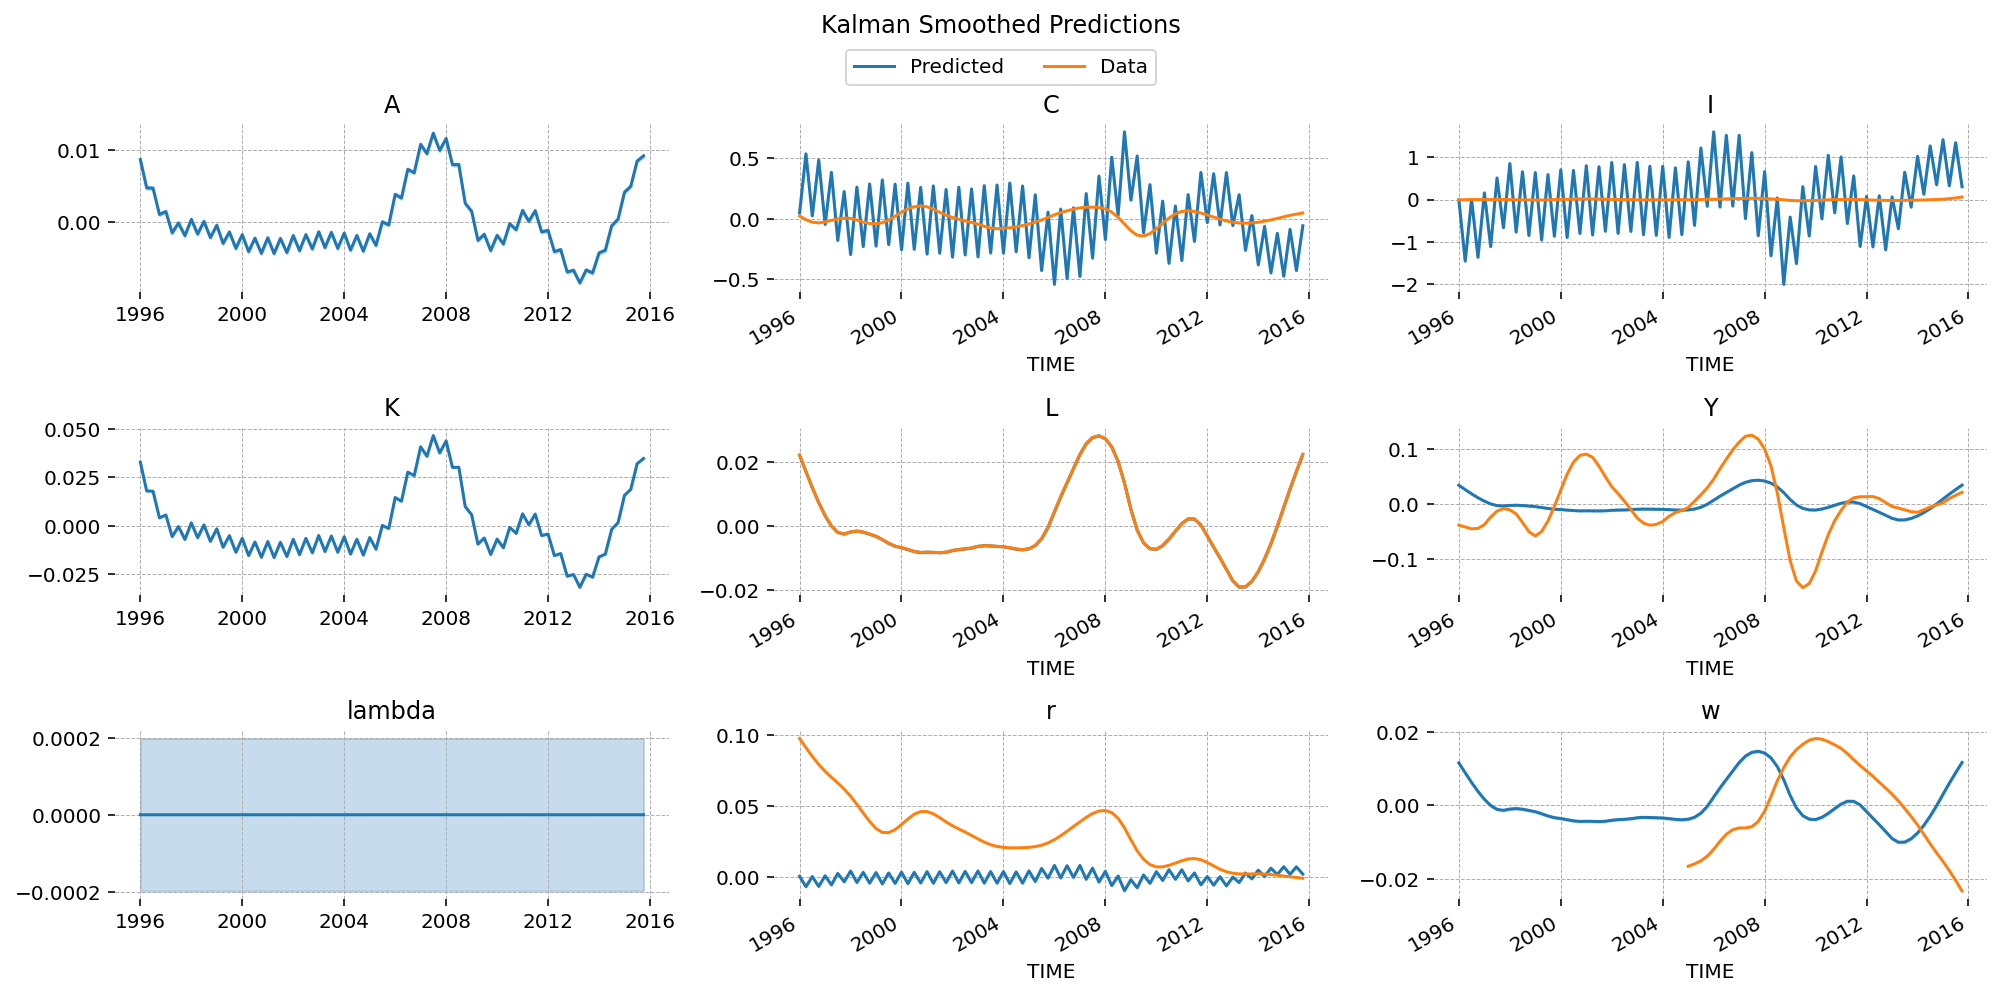

In [116]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="section_4_8"></a>

In [117]:
mle_forecast = mle_res.get_forecast(steps=test_size)

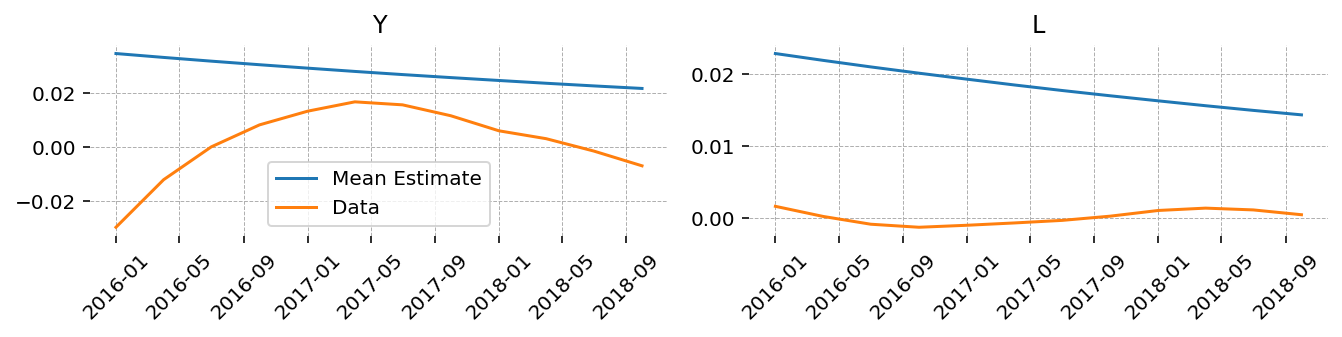

In [118]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'L'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

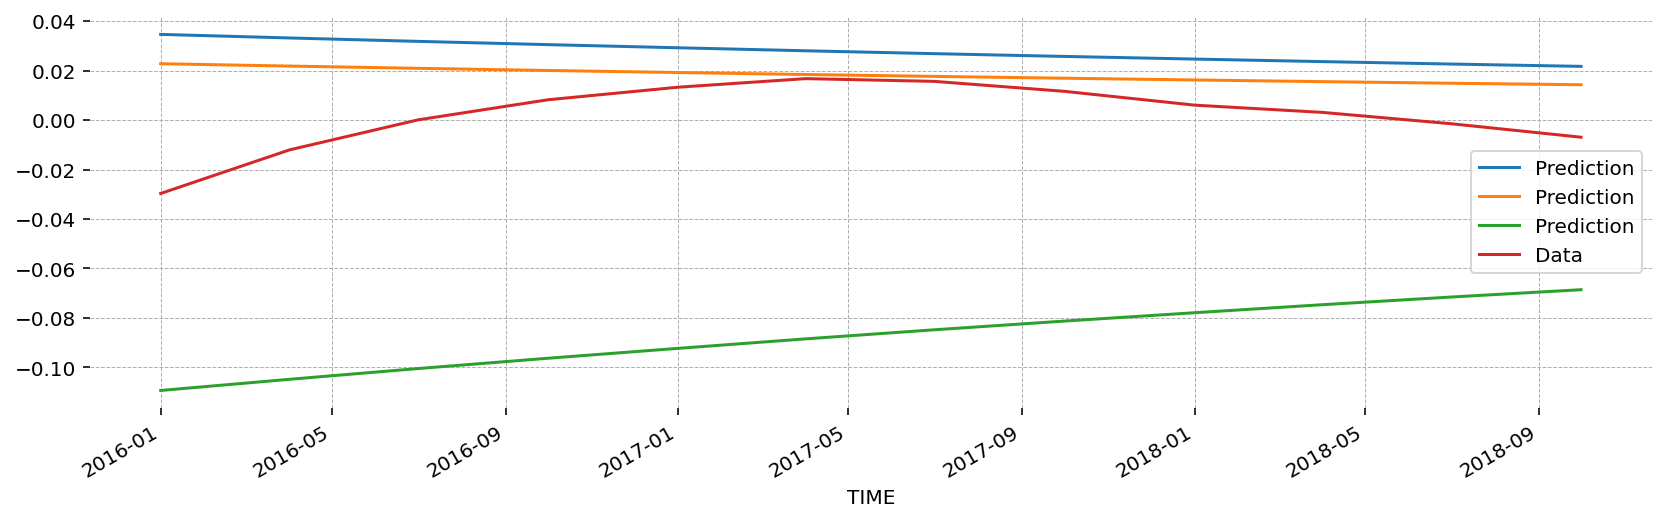

In [119]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

Our model has not correctly captured the notion of an overbooming economy, that evenutally declines. This could be an interpretation of the down-turn in 2017, which has been preceeded by years of recovery and subsquent boom of post 08.

## Impulse response <a class="anchor" id="section_4_5"></a>

In [120]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

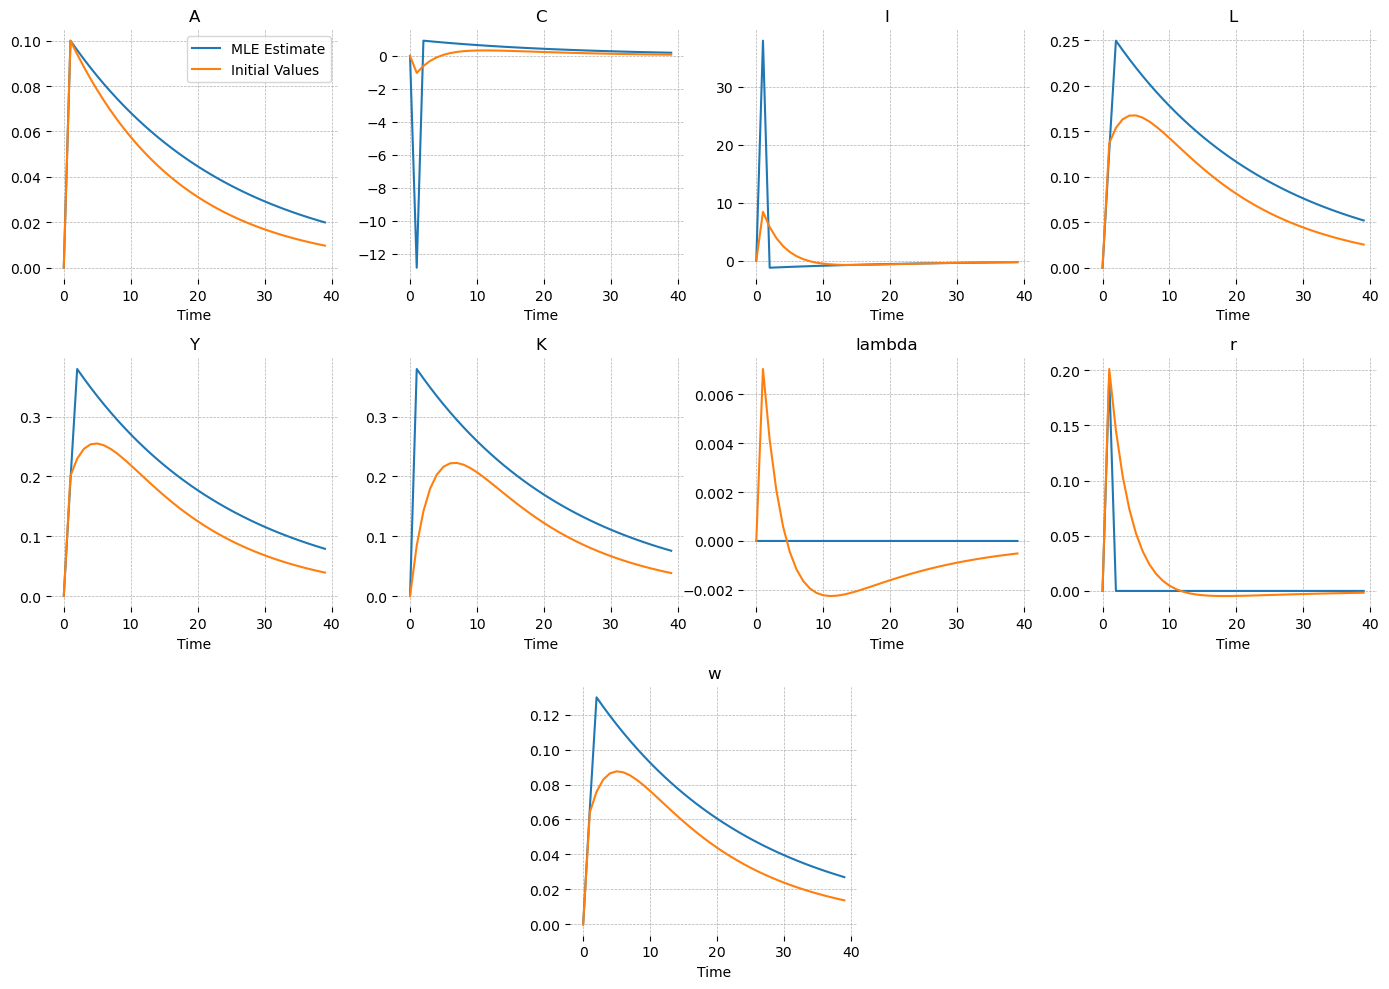

<Figure size 1400x1000 with 0 Axes>

In [121]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=plot_vars)
fig2 = gp.plot_irf(base_irf, vars_to_plot=plot_vars)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()

### New Steady State <a class="anchor" id="subsection_4_9"></a>

The new steady state has significantly higher capital K_ss and Y_ss as the ex-ante model.

In [122]:
rbc.print_steady_state()

A_ss               1.000
C_ss              12.029
I_ss               4.158
K_ss             415.769
L_ss               5.113
Y_ss              16.186
lambda_ss          1.000
r_ss               0.010
w_ss               2.336


In [123]:
mle_mod.param_names

['rho_A', 'sigma_C', 'sigma2.epsilon_A', 'sigma2.Y']